# Mitigating Bias in Machine Learning Models with Constraints
### Workshop for Strangeloop Conference — scheduled for September 30th, 2021 1:30 PM CST
### by Serg Masís ([LinkedIn](https://www.linkedin.com/in/smasis/), [Twitter](https://twitter.com/smasis), [Amazon](https://www.amazon.com/kindle-dbs/entity/author/B08PQ8P9BS?_encoding=UTF8&node=283155&offset=0&pageSize=12&searchAlias=stripbooks&sort=author-sidecar-rank&page=1&langFilter=default#formatSelectorHeader), [Serg.ai](https://www.serg.ai/), [Github](https://github.com/smasis001))

This notebook will walk through:

**PART I**

- Understanding the dataset and it's correlations using [Spearman's rank correlation coefficient](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html)
- Inspecting how several features relate to the target
- Deciding on a strategy based on domain expertise to train a high performing model with some safeguards to mitigate bias
- Performing data preparation steps to place guardrails (Ordinalization, Discretization and Interaction Terms and Non-linear Transformations)

**PART II**
- Training a regularized [XGBoost Classifier](https://xgboost.readthedocs.io/en/latest/python/python_api.html) "base" model
- Evaluating predictive performance for base model
- Examining SHAP Values with [SHAP summary](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html) — also know as a "beeswarm" chart.
- Studying Interactions with [SHAP Interaction Values](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Basic%20SHAP%20Interaction%20Value%20Example%20in%20XGBoost.html)
- Training an XGboost model using [monotonic constraints](https://xgboost.readthedocs.io/en/latest/tutorials/monotonic.html), and [interaction constraints](https://xgboost.readthedocs.io/en/latest/tutorials/feature_interaction_constraint.html).
- Comparing SHAP summaries side-by-side between both XGBoost models
- Comparing predictive performance metrics across "protected" features to ensure that from an outcome perspective, constrained model hasn't made things worse using [XAI](https://ethicalml.github.io/xai/index.html#model-evaluation)
- Implementing model constraints in [Tensorflow Lattice Keras Layers](https://www.tensorflow.org/lattice/tutorials/keras_layers)

For further background on Risk Recidivisim Assessments for COMPAS dataset:

- Angwin, J., Larson, J., Mattu, S., & Kirchner, L. (2016). Machine Bias. There is software that is
used across the county to predict future criminals. Propublica. [Article](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) | [Code Explanation](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) | [Code](https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb)

The dataset we will use has already been filtered as performed by ProPublica, and unnecessary columns removed, such as those that reveal the defendants' identities. Also, dataset has been balanced to mitigate some of the bias reported in the article. The original dataset can be  [found here](https://www.kaggle.com/danofer/compass?select=cox-violent-parsed_filt.csv).

## 1) Install Libraries
#### _(if not installed already)_

Only if not Google Colab because google colab has these preinstalled:

In [ ]:
!pip install --upgrade pandas numpy scikit-learn xgboost tensorflow pydot graphviz matplotlib seaborn scipy

Always installed unless installed already:

In [ ]:
#NOTE: It will show an error in Colab for xai 0.0.5. It will work regardless. 
# XAI doesn't really need exact versions of 6 different libraries to work.
!pip install --upgrade tensorflow-lattice shap
!pip install --no-deps --quiet git+https://github.com/EthicalML/xai.git

## 2) Load Libraries

In [1]:
import math
import os
import warnings
warnings.filterwarnings("ignore")

#DATA WRANGLING
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#MODELING
import xgboost as xgb
import tensorflow as tf
import tensorflow_lattice as tfl
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

#VISUALIZATION
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns

#FAIRNESS
import xai

#INTERPRETATION
from sklearn import metrics
import scipy
import shap

Check that we have the right version of Tensorflow:

In [2]:
print(tf.__version__)

2.2.1


## 3) Data Understanding

### 3.1) Load Dataset

We download the dataframe from a GIT repo and read as a CSV file into Pandas ensuring that the column datatypes are respected.

In [3]:
recidivism_df = pd.read_csv("https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/raw/master/datasets/recidivism-risk_balanced.csv",\
                            dtype={"age":"int8", "juv_fel_count":"int8", "juv_misd_count":"int8", "juv_other_count":"int8",\
                                   "priors_count":"int8", "compas_score":"int8", "is_recid":"int8"})

### 3.2) Verify Dataset

Should have 11,142 records and 12 columns. None of the columns have nulls, and there are three categorical (`object`) columns.

In [4]:
recidivism_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11142 entries, 0 to 11141
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sex                      11142 non-null  object 
 1   age                      11142 non-null  int8   
 2   race                     11142 non-null  object 
 3   juv_fel_count            11142 non-null  int8   
 4   juv_misd_count           11142 non-null  int8   
 5   juv_other_count          11142 non-null  int8   
 6   priors_count             11142 non-null  int8   
 7   c_charge_degree          11142 non-null  object 
 8   days_b_screening_arrest  11142 non-null  float64
 9   length_of_stay           11142 non-null  float64
 10  compas_score             11142 non-null  int8   
 11  is_recid                 11142 non-null  int8   
dtypes: float64(2), int8(7), object(3)
memory usage: 511.5+ KB


We can also gain an understanding of our data by taking a peek into first few records with `head`.

In [5]:
recidivism_df.sample(frac=1).head(10)

,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,days_b_screening_arrest,length_of_stay,compas_score,is_recid
1203,Female,25,African-American,0,0,0,0,(F3),-1.0,5.125000,1,0
2177,Male,26,African-American,0,1,0,6,(M2),-8.0,1.875000,1,0
6782,Male,24,Caucasian,0,1,1,3,(F3),0.0,0.166667,1,1
53,Male,22,African-American,0,0,1,3,(F3),0.0,323.083333,1,0
3411,Male,26,African-American,1,1,0,10,(F2),-1.0,29.708333,1,1
5962,Male,20,Caucasian,0,0,0,0,(F2),-1.0,140.041667,1,0
8007,Female,23,Caucasian,0,0,0,4,(M1),-1.0,222.208333,1,1
900,Male,35,African-American,0,0,0,0,(F3),0.0,-22.833333,1,0
3364,Male,37,African-American,1,8,5,23,(F2),-1.0,1.875000,1,1
10264,Male,24,Other,0,0,0,0,(M1),-1.0,1.125000,0,1


**Data Dictionary**

- `sex`: Categorical, the gender of the defendant.
- `age`: Continuous, the age of the defendant.
- `race`: Categorical, the race of the defendant.
- `juv_fel_count`: Continuous, the number of juvenile felonies.
- `juv_misd_count`: Continuous, the number of juvenile misdemeanors.
- `juv_other_count`: Continuous, the number of juvenile convictions that are neither felonies nor misdemeanors.
- `priors_count`: Continuous, the number of prior crimes committed (between 0 and 13).
- `c_charge_degree`: Categorical, the degree of what the defendant is currently being charged with. The United States classifies criminal offenses as felonies, misdemeanors, and infractions, ordered from most serious to least. These are subclassified in the form of degrees, which go from 1st (most serious offenses) to 3rd or 5th (least severe). However, even though this is standard for federal offenses, it is tailored to state law on a state level. For felonies, Florida (http://www.dc.state.fl.us/pub/scoresheet/cpc_manual.pdf) has a level system that determines the severity of a crime regardless of the degree, and this goes from 10 (most severe) to 1 (least). The categories of this feature are prefixed with F for felonies and M for misdemeanors. They are followed by a number, which is a level for felonies and a degree for misdemeanors.
- `days_b_screening_arrest`: Continuous, difference in days between COMPAS score screening date and (original) arrest date.
- `length_of_stay`: Continuous, days encarcerated after arrest.
- `compas_score`: Binary, COMPAS scores defendants as "low," "medium," or "high" risk. In practice, "medium" is often treated as "high" by decision-makers, so this feature has been converted to binary to reflect this behavior: 1: high/medium risk, 0: low risk.
- `is_recid`: **Target**, Binary, did the defendant recidivate within 2 years (1 for yes, 0 for no)?

### 3.3) Correlations

**Spearman's Rank Correlation Coefficient to Target**

One of the best measures of correlation of the dataset we can use is Spearman's. It goes from -1 to 1, where zero means no correlation and -1 means absolute negative correlation and 1 absolute positive correlation. In this case, we will generate a correlation matrix with `scipy` and take the last column which corresponds to correlations to the target variable. We will remove the last row because the target correlates perfectly with itself.

In [6]:
recidivism_corr_df = recidivism_df.drop(['compas_score'], axis=1)
pd.DataFrame({'feature': recidivism_corr_df.columns[:-1],\
              'correlation_to_target': scipy.stats.spearmanr(recidivism_corr_df).correlation[10,:-1]\
             }).style.background_gradient(cmap='coolwarm_r')

,feature,correlation_to_target
0,sex,0.093255
1,age,-0.155838
2,race,-0.004598
3,juv_fel_count,0.082138
4,juv_misd_count,0.117976
5,juv_other_count,0.125797
6,priors_count,0.283640
7,c_charge_degree,-0.037764
8,days_b_screening_arrest,0.032485
9,length_of_stay,0.012530


We can tell that `priors_count` is the feature that most correlates with the target and it does so positively. In other words as `priors_count` increases so does `is_recid`. Likewise, `age` is the feature that does so most negatively.

**Dendogram**

A Dendogram can map these correlations in accordance to their amount of correlation between each other.

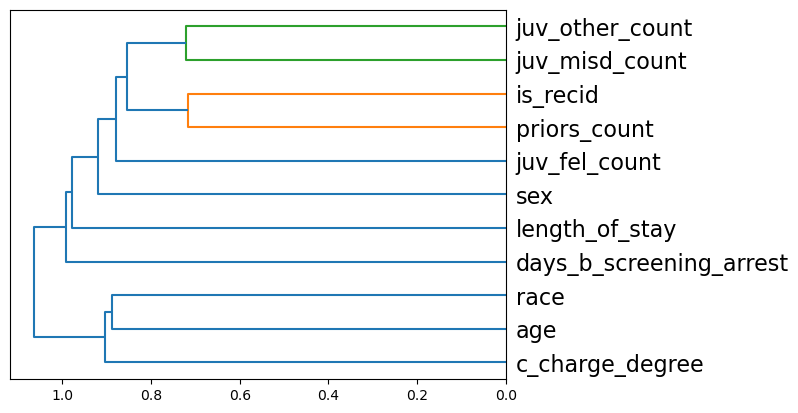

In [7]:
_ = xai.correlations(recidivism_corr_df, include_categorical=True)

It's not surprising that `priors_count` is closest to `is_recid`

**Spearman's to Prior's Count**

Since `priors_count` is so important, it makes sense to check how much other features correlates with it. 

In [8]:
pd.DataFrame({'feature': recidivism_corr_df.drop(['priors_count'], axis=1).columns,\
              'correlation_to_priors_cnt': np.delete(scipy.stats.spearmanr(recidivism_corr_df).correlation[6,:], 6, 0)\
             }).style.background_gradient(cmap='coolwarm_r')

,feature,correlation_to_priors_cnt
0,sex,0.103261
1,age,0.155096
2,race,-0.211489
3,juv_fel_count,0.172247
4,juv_misd_count,0.216738
5,juv_other_count,0.124896
6,c_charge_degree,-0.129557
7,days_b_screening_arrest,-0.010538
8,length_of_stay,0.091057
9,is_recid,0.283640


Juvenile offenses correlates with adult offenses. Also `race` does, but mostly because it correlates with `age`. We will need to suppress these in our model.

### 3.4) Inspecting Categorical/Ordinal Features against Target

### 3.4.1) Gender

Let's check how `sex` is distributed with the target:

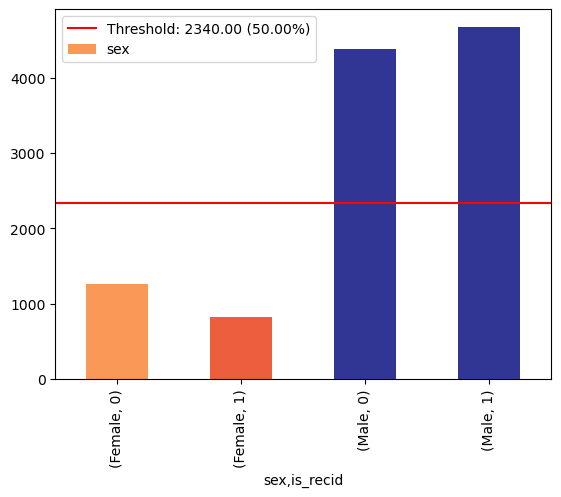

In [9]:
categorical_cols_l = ['sex', 'race', 'c_charge_degree',\
                      'is_recid', 'compas_score']
xai.imbalance_plot(recidivism_df, 'sex', 'is_recid',\
                   categorical_cols=categorical_cols_l)

### 3.4.2) Race

Let's check how `race` is distributed with the target:

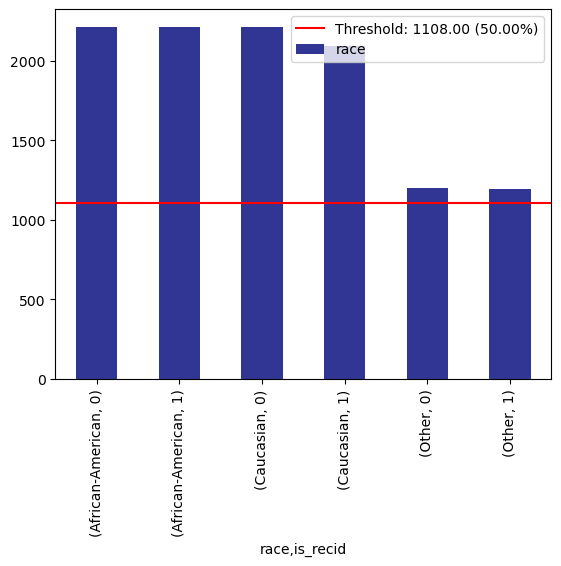

In [10]:
xai.imbalance_plot(recidivism_df, 'race', 'is_recid',\
                   categorical_cols=categorical_cols_l)

### 3.4.3) Age

Now let's see how `age` is distributed with the target, but we will have to bin it first.

In [11]:
def discretize(v, v_intervals, use_quartiles=False, use_continuous_bins=False):
    if isinstance(v, (pd.core.series.Series, np.ndarray)) and isinstance(v_intervals, (list, np.ndarray)) and len(np.unique(v)) != len(v_intervals):
        raise Exception("length of interval must match unique items in array")
        
    if isinstance(v, (str)) and isinstance(v_intervals, (list, np.ndarray)):
        #name of variable instead of array and list of intervals used
        if isinstance(v_intervals, list): v_intervals = np.array(v_intervals)
        return v, v_intervals
    
    if (np.isin(v.dtype, [int, float, 'int8', 'int16', 'int32', 'float16', 'float32'])) and (isinstance(v_intervals, (int))) and (len(np.unique(v)) >= v_intervals) and (max(v) > min(v)):
        #v is discretizable, otherwise assumed to be already discretized
        if use_continuous_bins:
            if use_quartiles:
                v, bins = pd.qcut(v, v_intervals, duplicates='drop', retbins=True, labels=True, precision=2)
            else:
                v, bins = pd.cut(v, v_intervals, duplicates='drop', retbins=True, labels=True, precision=2)
        else:
            if use_quartiles:
                v = pd.qcut(v, v_intervals, duplicates='drop', precision=2)
            else:
                v = pd.cut(v, v_intervals, duplicates='drop', precision=2)
        
    if np.isin(v.dtype, [object, 'category']):
        if not isinstance(v, (pd.core.series.Series)):
            v = pd.Series(v)
        bins = np.sort(np.unique(v)).astype(str)
        v = v.astype(str)
        bin_dict = {bins[i]:i for i in range(len(bins))} 
        v = v.replace(bin_dict)
    else:
        bins = np.unique(v)
        
    if isinstance(v_intervals, (list, np.ndarray)) and len(bins) == len(v_intervals):
        bins = v_intervals
                       
    return v, bins

def plot_prob_progression(x, y, x_intervals=7, use_quartiles=False,\
                          xlabel=None, ylabel=None, title=None, model=None, X_df=None, x_col=None,\
                         mean_line=False, figsize=(12,6), x_margin=0.01):
    if isinstance(x, list): x = np.array(x)
    if isinstance(y, list): y = np.array(y)
    if (not isinstance(x, (str, pd.core.series.Series, np.ndarray))) or (not isinstance(y, (str, pd.core.series.Series, np.ndarray))):
        raise Exception("x and y must be either lists, pandas series or numpy arrays. x can be string when dataset is provided seperately")
    if (isinstance(x, (pd.core.series.Series, np.ndarray)) and (len(x.shape) != 1)) or ((isinstance(y, (pd.core.series.Series, np.ndarray))) and (len(y.shape) != 1)):
        raise Exception("x and y must have a single dimension")
    if (isinstance(x_intervals, (int)) and (x_intervals < 2)) or (isinstance(x_intervals, (list, np.ndarray)) and (len(x_intervals) < 2)):
        raise Exception("there must be at least two intervals to plot")
    if not np.isin(y.dtype, [int, float, 'int8', 'int16', 'int32', 'float16', 'float32']):
        raise Exception("y dimension must be a list, pandas series or numpy array of integers or floats")
    if max(y) == min(y):
        raise Exception("y dimension must have at least two values")
    elif len(np.unique(y)) == 2 and ((max(y) != 1) or (min(y) != 0)):
        raise Exception("y dimension if has two values must have a max of exactly 1 and min of exactly zero")
    elif len(np.unique(y)) > 2 and ((max(y) <= 1) or (min(y) >= 0)):
        raise Exception("y dimension if has more than two values must have range between between 0-1")
    x_use_continuous_bins = (model is not None) and (isinstance(x_intervals, (list, np.ndarray)))
    x, x_bins = discretize(x, x_intervals, use_quartiles, x_use_continuous_bins)
    x_range = [*range(len(x_bins))]
    plot_df = pd.DataFrame({'x':x_range})
    if (model is not None) and (X_df is not None) and (x_col is not None):
        preds = model.predict(X_df).squeeze()
        if len(np.unique(preds)) <= 2:
            preds = model.predict_proba(X_df)[:,1]
        x_, _ = discretize(X_df[x_col], x_intervals, use_quartiles, x_use_continuous_bins)
        xy_df = pd.DataFrame({'x':x_, 'y':preds})
    else:
        xy_df = pd.DataFrame({'x':x,'y':y})
    probs_df = xy_df.groupby(['x']).mean().reset_index()
    probs_df = pd.merge(plot_df, probs_df, how='left', on='x').fillna(0)
    
    sns.set()
    x_bin_cnt = len(x_bins)
    l_width = 0.933
    r_width = 0.05
    w, h = figsize
    wp = (w-l_width-r_width)/9.27356902357
    xh_margin = ((wp-(x_margin*2))/(x_bin_cnt*2))+x_margin
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=figsize,\
                                   gridspec_kw={'height_ratios': [3, 1]})
    if title is not None:
        fig.suptitle(title, fontsize=21)
        plt.subplots_adjust(top = 0.92, bottom=0.01, hspace=0.001, wspace=0.001)
    else:
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.001, wspace=0.001)
    ax0.minorticks_on()
    sns.lineplot(data=probs_df, x='x', y='y', ax=ax0)
    ax0.set_ylabel('Probability', fontsize=15)
    ax0.set_xlabel('')
    ax0.grid(b=True, axis='x', which='minor', color='w', linestyle=':')
    #ax0.set_xticks([], [])
    ax0.margins(x=xh_margin)
    if mean_line:
        ax0.axhline(y=xy_df.y.mean(), c='red', linestyle='dashed', label="mean")
        ax0.legend()
    sns.histplot(xy_df, x="x", stat='probability', bins=np.arange(x_bin_cnt+1)-0.5, ax=ax1)
    ax1.set_ylabel('Observations', fontsize=15)
    ax1.set_xlabel(xlabel, fontsize=15)
    ax1.xaxis.set_major_locator(plticker.MultipleLocator(base=1.0))
    ax1.set_xticklabels(['']+list(x_bins))
    ax1.margins(x=x_margin)
    plt.show()

We will use the function above to plot it with fix-width bins:

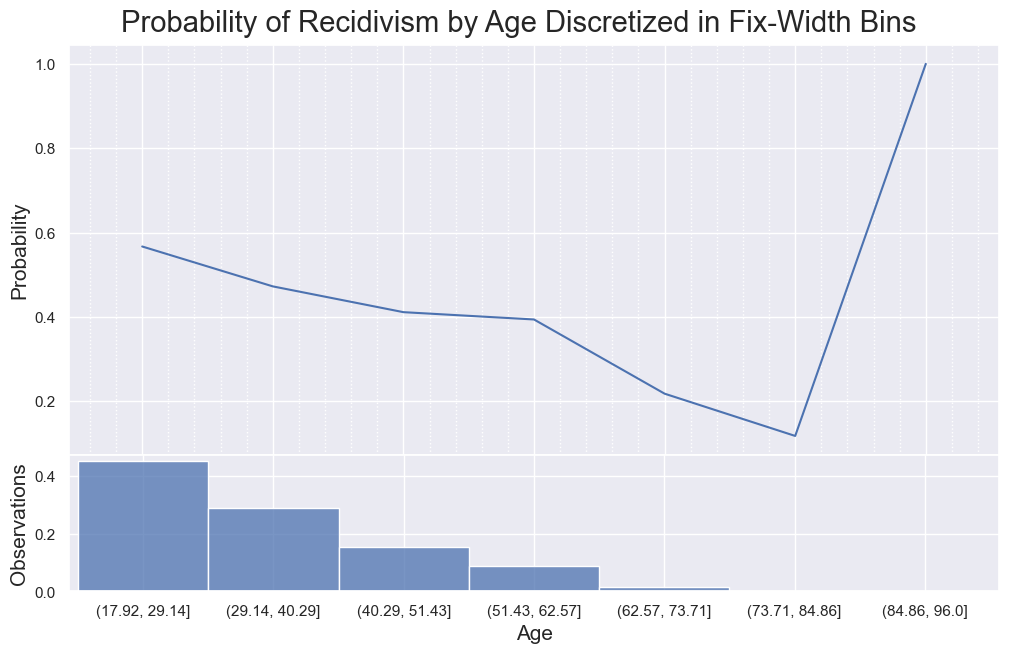

In [12]:
plot_prob_progression(recidivism_df.age, recidivism_df.is_recid,\
                                 x_intervals=7, use_quartiles=False, xlabel='Age',\
                title='Probability of Recidivism by Age Discretized in Fix-Width Bins')

As you can see these don't work because since some age groups are so sparse, it is better to bin them according to quartiles like this:

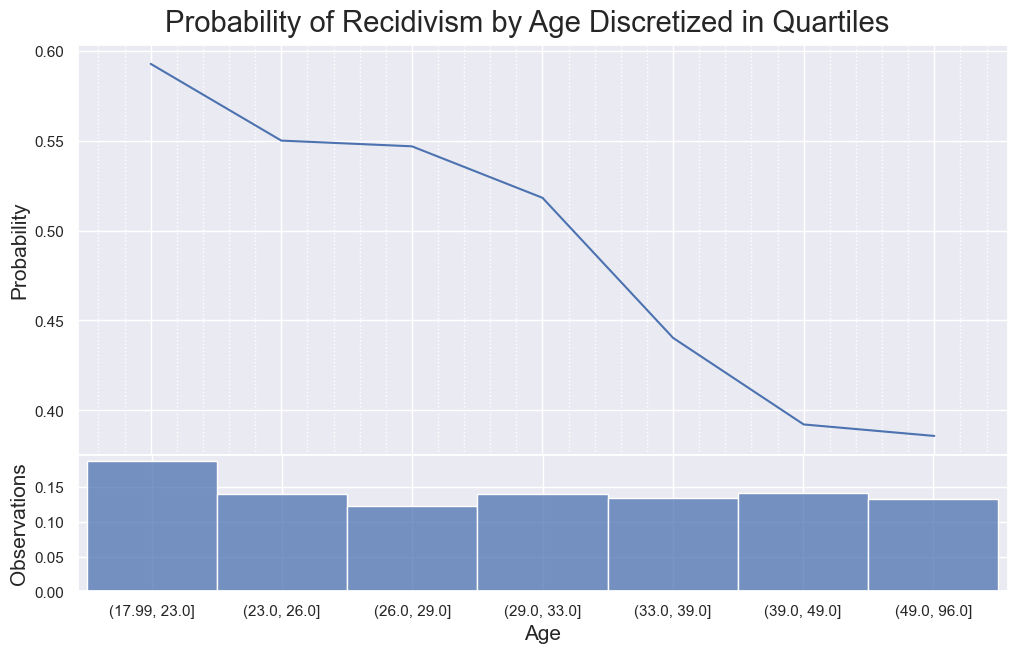

In [13]:
plot_prob_progression(recidivism_df.age, recidivism_df.is_recid,\
                                 x_intervals=7, use_quartiles=True, xlabel='Age',\
                title='Probability of Recidivism by Age Discretized in Quartiles')

It dicreases as expected.

### 3.4.4) Priors Count

We will do the same with `priors_count`:

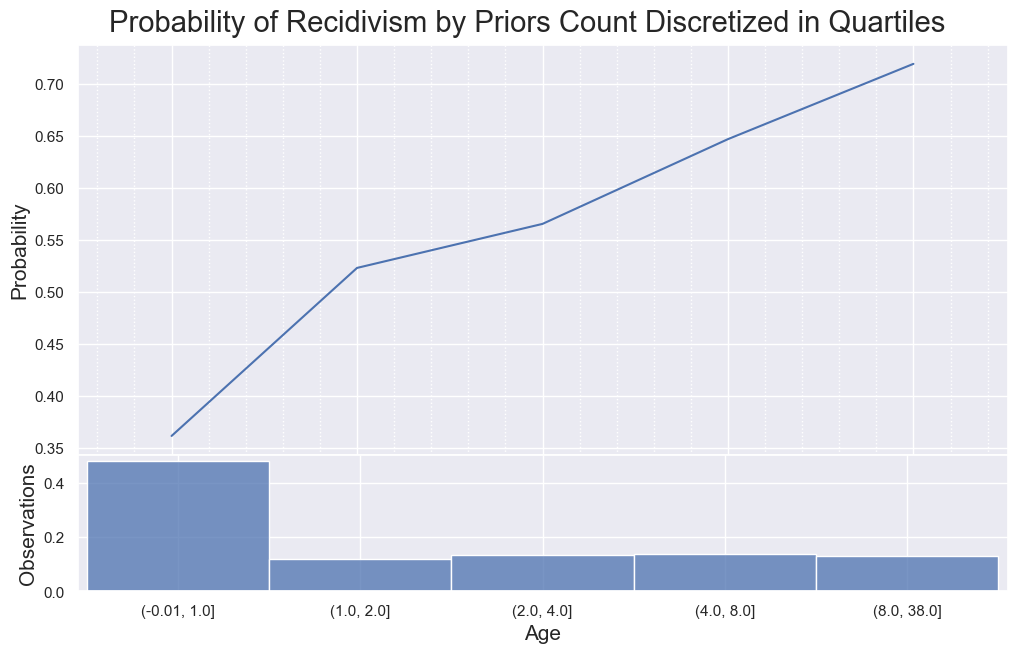

In [14]:
plot_prob_progression(recidivism_df.priors_count, recidivism_df.is_recid,\
                                 x_intervals=7, use_quartiles=True, xlabel='Age',\
                title='Probability of Recidivism by Priors Count Discretized in Quartiles')

It increases as expected.

### 3.4.5) Charge Degree

In [15]:
#List count for each category in `c_charge_degree` in descending order.
recidivism_df.c_charge_degree.value_counts()

(F3)     6555
(M1)     2632
(F2)      857
(M2)      768
(F1)      131
(F7)      104
(MO3)      76
(F5)        7
(F6)        5
(NI0)       4
(CO3)       2
(TCX)       1
Name: c_charge_degree, dtype: int64

### 3.4.6) Recapping Domain Expertise

1. `priors_count`: Prior offenses is the biggest predictor of recidivisim
2. `age`: As age decreases so does likelihood to recidivate. It has a natural connection with `priors_count` because the older you are the more priors you are likely to have. But: 
- we don't want to penalize older folks for what they did 20 years ago, and
- at the current granulatity, it correlates a lot with `race`.
3. `juv_fel_count`, `juv_misd_count` and `juv_other_count`: Juvenile offenses are problematic features because they correlate with `age` and thus `race`. We shall supress these relationships.
4. `gender`: Females are less likely to recidivate. This is a known phenomena with mostly societal and some biological explanations. We won't take it out of the equation but will also suppress it.
5. `c_charge_degree`: it makes sense to use the degree of what the defendant is currently being charged with as a predictor for recividism. However, not as a categorical but an ordinal feature.

## 4) Data Preparation

### 4.1) Ordinalization

Replace categories for numbers that correspond to their order of severity.

In [16]:
charge_degree_code_rank = {'(F10)': 15, '(F9)':14, '(F8)':13, '(F7)':12, '(TCX)':11, '(F6)':10, '(F5)':9,\
                           '(F4)':8, '(F3)':7, '(F2)':6, '(F1)':5, '(M1)':4, '(NI0)':4, '(M2)':3,\
                           '(CO3)':2, '(MO3)':1, '(X)':0}
recidivism_df.c_charge_degree.replace(charge_degree_code_rank, inplace=True)

Plot the probability recidivism will increase according to this severity

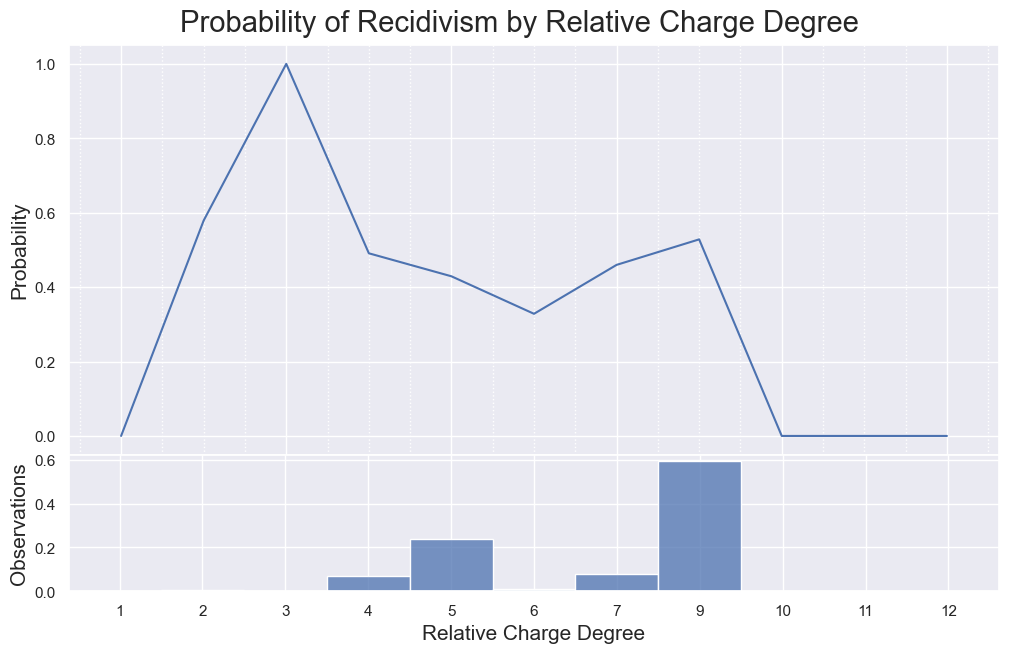

In [17]:
plot_prob_progression(recidivism_df.c_charge_degree, recidivism_df.is_recid,\
                    x_intervals=12, use_quartiles=False, xlabel='Relative Charge Degree',\
                    title='Probability of Recidivism by Relative Charge Degree')

### 4.2) Discretization

Now, let's create age groups with the quartiles we observed.

In [18]:
recidivism_df['age_group'] = pd.qcut(recidivism_df.age, 7, precision=0).astype(str)

We can plot these age groups in the same way we did with `c_charge_degree`.

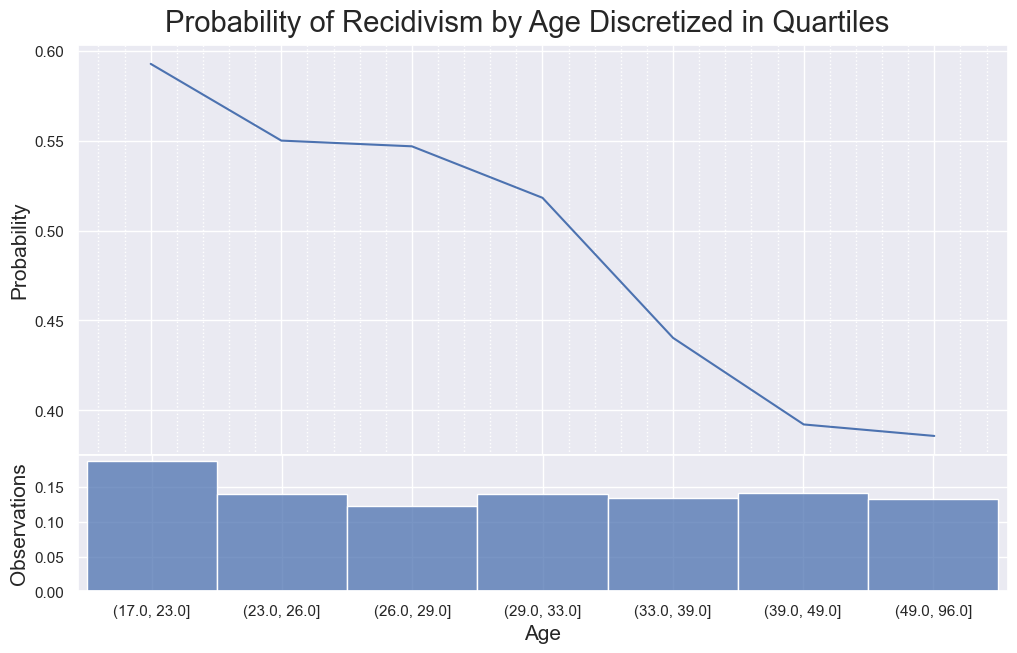

In [19]:
plot_prob_progression(recidivism_df.age_group, recidivism_df.is_recid,\
                                 x_intervals=7, use_quartiles=False, xlabel='Age',\
                title='Probability of Recidivism by Age Discretized in Quartiles')

### 4.3) Interaction Terms and Non-linear Transformations

Let's tidy up the relationship between `age` and `priors_count` but first we will turn the plot above into a 3-dimensional one:

In [20]:
def plot_prob_contour_map(x, y, z, x_intervals=7, y_intervals=7, use_quartiles=False, plot_type='contour',\
                          xlabel=None, ylabel=None, title=None, model=None, X_df=None, x_col=None, y_col=None,\
                          diff_to_mean=False, annotate=False):
    if isinstance(x, list): x = np.array(x)
    if isinstance(y, list): y = np.array(y)
    if isinstance(z, list): z = np.array(z)
    if (not isinstance(x, (str, pd.core.series.Series, np.ndarray))) or (not isinstance(y, (str, pd.core.series.Series, np.ndarray))) or (not isinstance(z, (pd.core.series.Series, np.ndarray))):
        raise Exception("x, y and z must be either lists, pandas series or numpy arrays. x and y can be strings when dataset is provided seperately")
    if (isinstance(x, (pd.core.series.Series, np.ndarray)) and (len(x.shape) != 1)) or ((isinstance(y, (pd.core.series.Series, np.ndarray))) and (len(y.shape) != 1)) or (len(z.shape) != 1):
        raise Exception("x, y and z must have a single dimension")
    if (isinstance(x_intervals, (int)) and (x_intervals < 2)) or (isinstance(x_intervals, (list, np.ndarray)) and (len(x_intervals) < 2)) or (isinstance(y_intervals, (int)) and (y_intervals < 2)) or (isinstance(y_intervals, (list, np.ndarray)) and (len(y_intervals) < 2)):
        raise Exception("there must be at least two intervals to contour")
    if not np.isin(z.dtype, [int, float, 'int8', 'int16', 'int32', 'float16', 'float32']):
        raise Exception("z dimension must be a list, pandas series or numpy array of integers or floats")
    if max(z) == min(z):
        raise Exception("z dimension must have at least two values")
    elif len(np.unique(z)) == 2 and ((max(z) != 1) or (min(z) != 0)):
        raise Exception("z dimension if has two values must have a max of exactly 1 and min of exactly zero")
    elif len(np.unique(z)) > 2 and ((max(z) <= 1) or (min(z) >= 0)):
        raise Exception("z dimension if has more than two values must have range between between 0-1")
    x_use_continuous_bins = (model is not None) and (isinstance(x_intervals, (list, np.ndarray)))
    y_use_continuous_bins = (model is not None) and (isinstance(y_intervals, (list, np.ndarray)))
    x, x_bins = discretize(x, x_intervals, use_quartiles, x_use_continuous_bins)
    y, y_bins = discretize(y, y_intervals, use_quartiles, y_use_continuous_bins)
    x_range = [*range(len(x_bins))]
    #if isinstance(y_intervals, (int)):
    y_range = [*range(len(y_bins))]
    #else:
    #y_range = y_intervals
    x_grid, y_grid = np.meshgrid(x_range, y_range)
    positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
    plot_df = pd.DataFrame(positions.T, columns=['x', 'y'])
    
    if (model is not None) and (X_df is not None) and (x_col is not None) and (y_col is not None):
        preds = model.predict(X_df).squeeze()
        if len(np.unique(preds)) <= 2:
            preds = model.predict_proba(X_df)[:,1]
        x_, _ = discretize(X_df[x_col], x_intervals, use_quartiles, x_use_continuous_bins)
        y_, _ = discretize(X_df[y_col], y_intervals, use_quartiles, y_use_continuous_bins)
        xyz_df = pd.DataFrame({'x':x_, 'y':y_, 'z':preds})
    else:
        xyz_df = pd.DataFrame({'x':x,'y':y,'z':z})
    probs_df = xyz_df.groupby(['x','y']).mean().reset_index()        
    probs_df = pd.merge(plot_df, probs_df, how='left', on=['x','y']).fillna(0)
    if diff_to_mean:
        expected_value = xyz_df.z.mean()
        probs_df['z'] = probs_df['z'] - expected_value
        cmap = plt.cm.RdYlBu
    else:
        cmap = plt.cm.viridis
    grid_probs = np.reshape(probs_df.z.to_numpy(), x_grid.shape)

    x_bin_cnt = len(x_bins)
    y_bin_cnt = len(y_bins)
    fig, (ax_top, ax_bottom) = plt.subplots(2, 2, figsize=(12,9),\
                                   gridspec_kw={'height_ratios': [1, 7], 'width_ratios': [6, 1]})
    if title is not None:
        fig.suptitle(title, fontsize=21)
        plt.subplots_adjust(top = 0.95, bottom=0.01, hspace=0.001, wspace=0.001)
    else:
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.001, wspace=0.001)

    sns.set_style(None)
    sns.set_style({'axes.facecolor':'white', 'grid.color': 'white'})
    sns.histplot(xyz_df, x='x', stat='probability', bins=np.arange(x_bin_cnt+1)-0.5, color=('dimgray',), ax=ax_top[0])
    ax_top[0].set_xticks([])
    ax_top[0].set_yticks([])
    ax_top[0].set_xlabel('')
    ax_top[0].set_ylabel('')
    ax_top[1].set_visible(False)

    if plot_type == 'contour':
        ax_bottom[0].contour(
            x_grid,
            y_grid,
            grid_probs,
            colors=('w',)
        )
        mappable = ax_bottom[0].contourf(
            x_grid,
            y_grid,
            grid_probs,
            cmap=cmap
        ) 
    else:
        mappable = ax_bottom[0].imshow(grid_probs, cmap=plt.cm.viridis,\
                                      interpolation='nearest', aspect='auto')
        if annotate:
            for i in range(y_bin_cnt):
                for j in range(x_bin_cnt):
                    text = ax_bottom[0].text(j, i, "{:.1%}".format(grid_probs[i, j]), fontsize=16,
                                             ha="center", va="center", color="w")
            ax_bottom[0].grid(False)
            
    ax_bottom[0].xaxis.set_major_locator(plticker.MultipleLocator(base=1.0))
    ax_bottom[0].set_xticklabels([''] + list(x_bins))
    ax_bottom[0].yaxis.set_major_locator(plticker.MultipleLocator(base=1.0))
    ax_bottom[0].set_yticklabels([''] + list(y_bins))
    #ax_bottom[0].margins(x=0.04, y=0.04)

    if xlabel is not None:
        ax_bottom[0].set_xlabel(xlabel, fontsize=15)
        
    if ylabel is not None:
        ax_bottom[0].set_ylabel(ylabel, fontsize=15)

    cbar = plt.colorbar(mappable, ax=ax_bottom[1])
    cbar.ax.set_ylabel('Probability', fontsize=13)
    cbar.ax.tick_params(labelsize=11)

    sns.histplot(xyz_df, y="y", stat='probability', bins=np.arange(y_bin_cnt+1)-0.5, color=('dimgray',), ax=ax_bottom[1])
    ax_bottom[1].set_xticks([])
    ax_bottom[1].set_yticks([])
    ax_bottom[1].set_xlabel('')
    ax_bottom[1].set_ylabel('')
    sns.set_style(None)

    plt.show()

Now we will plot how probability of `is_recid` increases with `age` and `priors_count`:

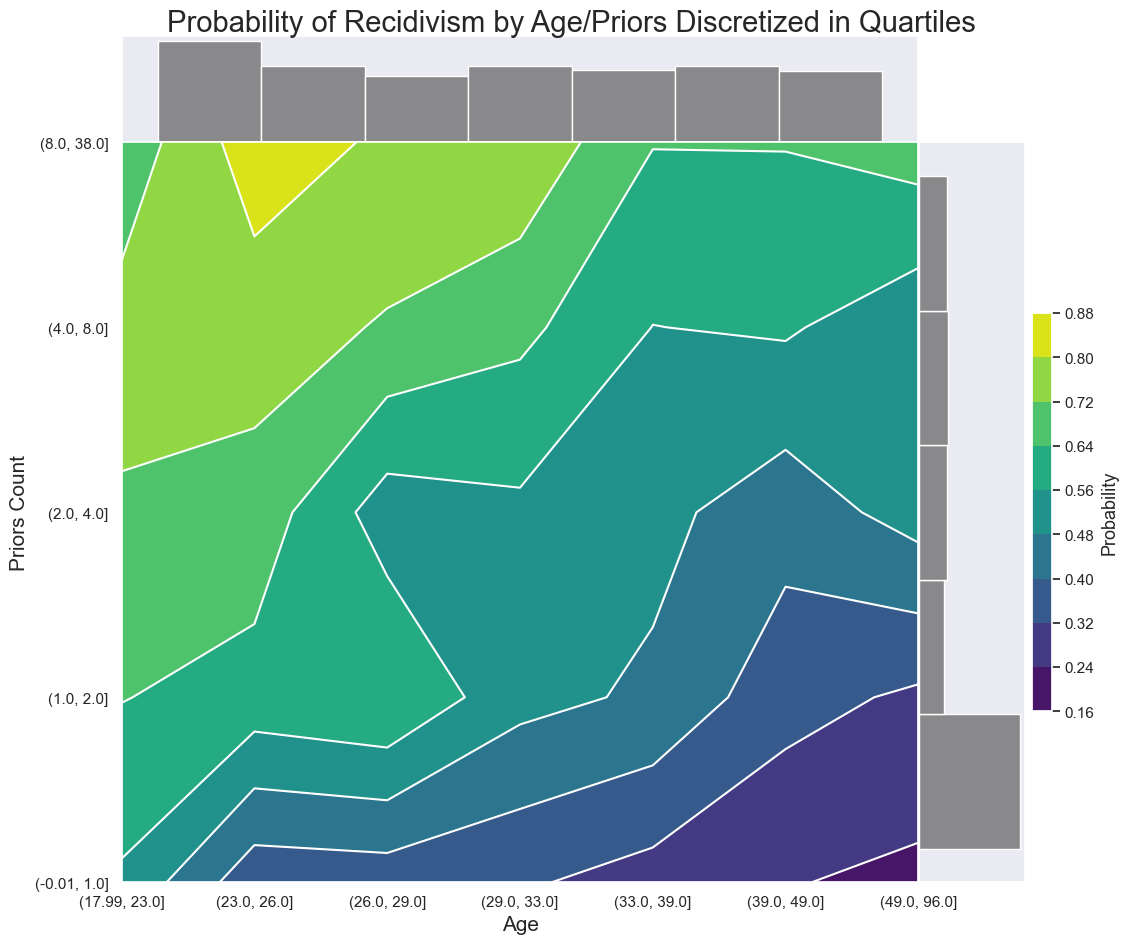

In [21]:
plot_prob_contour_map(recidivism_df.age, recidivism_df.priors_count, recidivism_df.is_recid,\
                                 use_quartiles=True, xlabel='Age', ylabel='Priors Count',\
                 title='Probability of Recidivism by Age/Priors Discretized in Quartiles')

We can capture the essense of this relationship with the following ratio:

In [22]:
recidivism_df['priors_per_year'] = recidivism_df['priors_count']/(recidivism_df['age'] - 17)

Now, let plot the `priors_per_year` ratio:

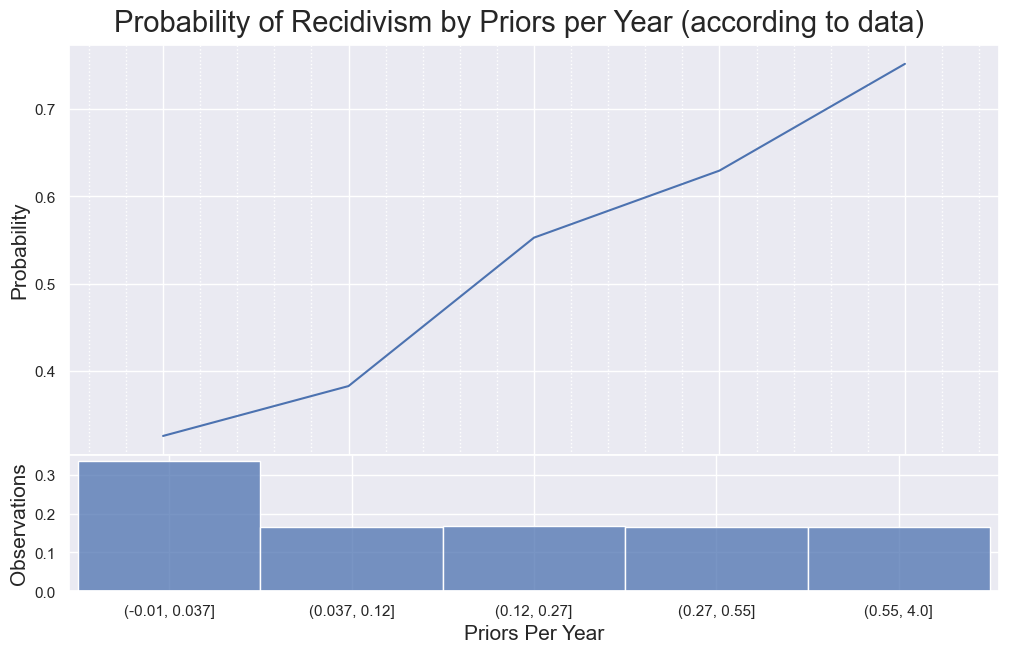

In [23]:
plot_prob_progression(recidivism_df.priors_per_year, recidivism_df.is_recid,\
                     x_intervals=6, use_quartiles=True, xlabel='Priors Per Year',\
            title='Probability of Recidivism by Priors per Year (according to data)')

And let's a contour plot between `priors_per_year` and `age_group`:

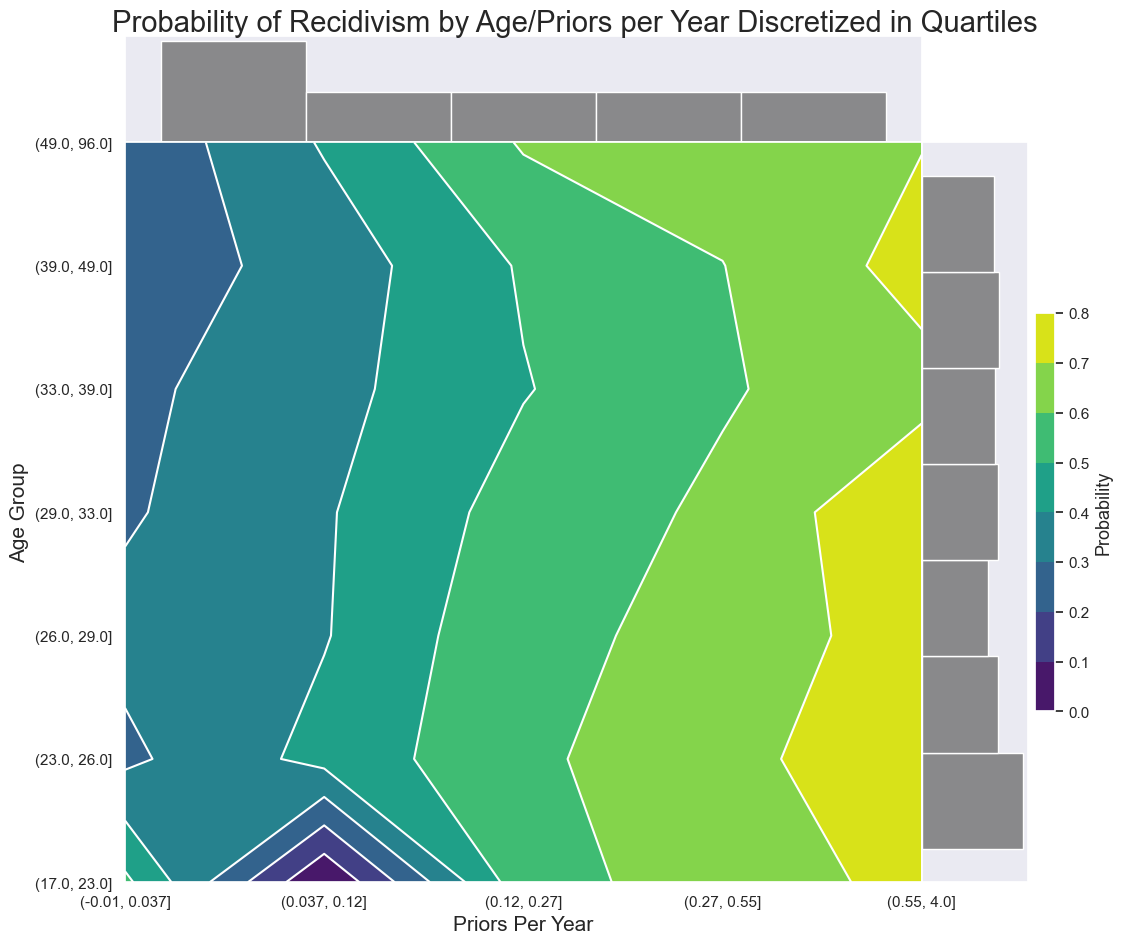

In [24]:
plot_prob_contour_map(recidivism_df.priors_per_year, recidivism_df.age_group,\
                                 recidivism_df.is_recid, x_intervals=6, use_quartiles=True,\
                                 xlabel='Priors Per Year', ylabel='Age Group',\
            title='Probability of Recidivism by Age/Priors per Year Discretized in Quartiles')

It moves now mostly horizontally. This is great because we don't want `age_groups` to have an outsized influence.

### 4.4) Categorical Encoding

In [25]:
cat_feat_l = ['sex', 'race', 'age_group']
ordenc = preprocessing.OrdinalEncoder(dtype=np.int8)
recidivism_df[cat_feat_l] = ordenc.fit_transform(recidivism_df[cat_feat_l])

### 4.5) Other Preparations

**Drop unnecessary columns**

In [26]:
recidivism_df.drop(['age', 'priors_count', 'compas_score'], axis=1, inplace=True)

**Set Random Seed**

In [27]:
#For reproducibility, it's imperative to consistently use a seed number and set it to NumPy, 
# tensorflow or in whatever place a stochastic process exists and allows for it to be set.
rand = 9
os.environ['PYTHONHASHSEED'] = str(rand)
tf.random.set_seed(rand)
np.random.seed(rand)

**Train/Test Split**

In [28]:
#Create `X` and `y` and split them 80/20 corresponding for train/test.
y = recidivism_df['is_recid']
X = recidivism_df.drop(['is_recid'], axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand)
recidivism_df = X.join(y)

Just for showing results:

In [29]:
X_test_display = X_test.copy()
X_test_display[cat_feat_l] = ordenc.inverse_transform(X_test_display[cat_feat_l])

### 4.5) Check correlations again

Let's compare these with those in **§3.3**

In [30]:
pd.DataFrame({'feature': recidivism_df.columns[:-1],\
              'correlation_to_target': scipy.stats.spearmanr(recidivism_df).correlation[10,:-1]\
             }).style.background_gradient(cmap='coolwarm_r')

,feature,correlation_to_target
0,sex,0.093255
1,race,-0.004598
2,juv_fel_count,0.082138
3,juv_misd_count,0.117976
4,juv_other_count,0.125797
5,c_charge_degree,0.069803
6,days_b_screening_arrest,0.032485
7,length_of_stay,0.012530
8,age_group,-0.152131
9,priors_per_year,0.321269


They are very similar except `priors_per_year` is stronger than `priors_count`

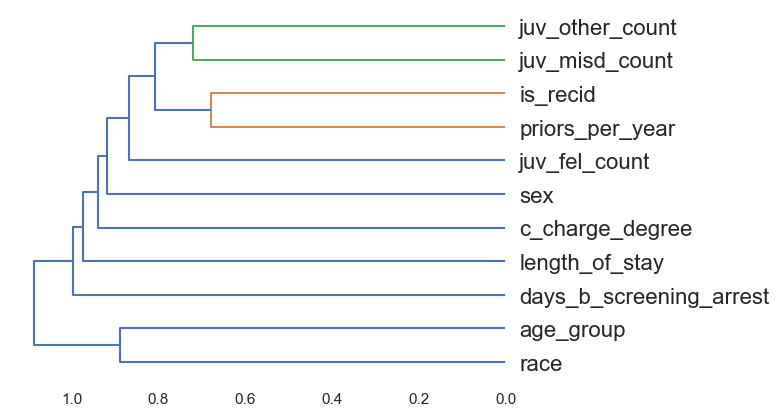

In [31]:
_ = xai.correlations(recidivism_df, include_categorical=True)

In [32]:
pd.DataFrame({'feature': recidivism_df.drop(['priors_per_year'], axis=1).columns,\
              'correlation_to_priors_per_year': np.delete(scipy.stats.spearmanr(recidivism_df).correlation[9,:], 9, 0)\
             }).style.background_gradient(cmap='coolwarm_r')

,feature,correlation_to_priors_per_year
0,sex,0.112009
1,race,-0.237612
2,juv_fel_count,0.221740
3,juv_misd_count,0.302530
4,juv_other_count,0.222313
5,c_charge_degree,0.153247
6,days_b_screening_arrest,-0.004528
7,length_of_stay,0.085675
8,age_group,-0.156581
9,is_recid,0.321269


However many features now correlate more strongly with `priors_per_year`. Model constraints can take care of what is undesirable here.

## 5) Training + Evaluating a base XGBoost Model

### 5.1) Train Base Model

Initialize and fit model with regularization parameters:

In [33]:
xgb_base_mdl = xgb.XGBClassifier(seed=rand, eta=1, max_depth=7, scale_pos_weight=0.7, reg_lambda=1.5, reg_alpha=1)
xgb_base_mdl = xgb_base_mdl.fit(X_train, y_train)

[07:55:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### 5.2) Evaluate Predictive Performance of Base Model

Define a simple evaluation function:

In [34]:
def evaluate_class_mdl(fitted_model, X_train, X_test, y_train, y_test, pct=True, thresh=0.5):
    y_train_pred = fitted_model.predict(X_train).squeeze()
    if len(np.unique(y_train_pred)) > 2:
        y_train_pred = np.where(y_train_pred > thresh, 1, 0)
        y_test_prob = fitted_model.predict(X_test).squeeze()
        y_test_pred = np.where(y_test_prob > thresh, 1, 0)
    else:   
        y_test_prob = fitted_model.predict_proba(X_test)[:,1]
        y_test_pred = np.where(y_test_prob > thresh, 1, 0)
    roc_auc = metrics.roc_auc_score(y_test, y_test_prob)
    plt.figure(figsize = (12,12))
    plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_test_prob)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # coin toss line
    plt.xlabel('False Positive Rate', fontsize = 14)
    plt.ylabel('True Positive Rate', fontsize = 14)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.legend(loc="lower right")
    plt.show()
    print('Accuracy_train:  %.4f\t\tAccuracy_test:   %.4f' %\
                        (metrics.accuracy_score(y_train, y_train_pred),\
                         metrics.accuracy_score(y_test, y_test_pred)))
    print('Precision_test:  %.4f\t\tRecall_test:     %.4f' %\
                        (metrics.precision_score(y_test, y_test_pred),\
                         metrics.recall_score(y_test, y_test_pred)))
    print('ROC-AUC_test:    %.4f\t\tF1_test:         %.4f\t\tMCC_test: %.4f' %\
                        (roc_auc,\
                         metrics.f1_score(y_test, y_test_pred),\
                         metrics.matthews_corrcoef(y_test, y_test_pred)))
    cf_matrix = metrics.confusion_matrix(y_test,\
                                         y_test_pred)
    plt.figure(figsize=(6, 5))
    if pct:
        sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,\
                    fmt='.2%', cmap='Blues', annot_kws={'size':16})
    else:
        sns.heatmap(cf_matrix, annot=True,\
                    fmt='d',cmap='Blues', annot_kws={'size':16})
    plt.show()
    return y_train_pred, y_test_prob, y_test_pred


Run the evaluation function against the base model:

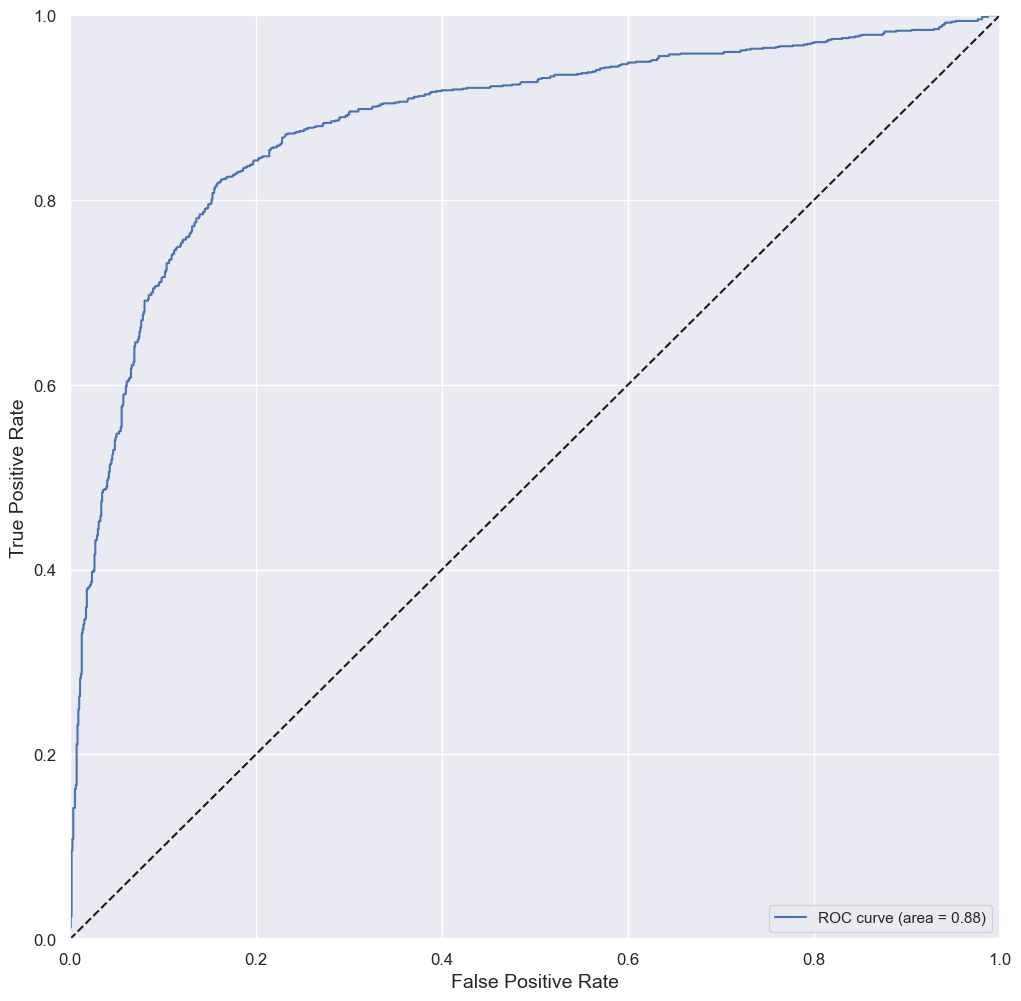

Accuracy_train:  0.9671		Accuracy_test:   0.8286
Precision_test:  0.8398		Recall_test:     0.8191
ROC-AUC_test:    0.8830		F1_test:         0.8293		MCC_test: 0.6575


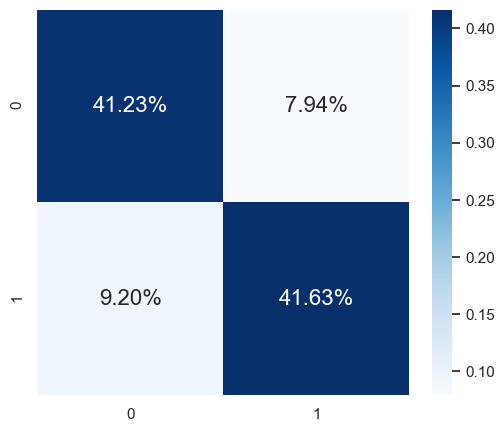

In [35]:
sns.set_style("darkgrid")
y_train_base_pred, y_test_base_prob, y_test_base_pred =\
                                                evaluate_class_mdl(xgb_base_mdl, X_train, X_test, y_train, y_test)

From the optics of fairness, we care more about false positives than false negatives because it's more unfair to put an "innocent" person in prison than leaving a "guilty" person in the streets. Therefore, we should aspire to have higher _precision_ than _recall_. The above metrics confirm this, as well as a healthy ROC curve, ROC-AUC and Matthews Correlation Coefficient (MCC).

### 5.3) Examine SHAP Values with SHAP summary

Initailize `TreeExplainer` for the model and generate SHAP values for the test data:

In [36]:
shap_xgb_base_explainer = shap.TreeExplainer(xgb_base_mdl)
shap_xgb_base_values = shap_xgb_base_explainer.shap_values(X_test)

Plot a SHAP summary based on those SHAP values:

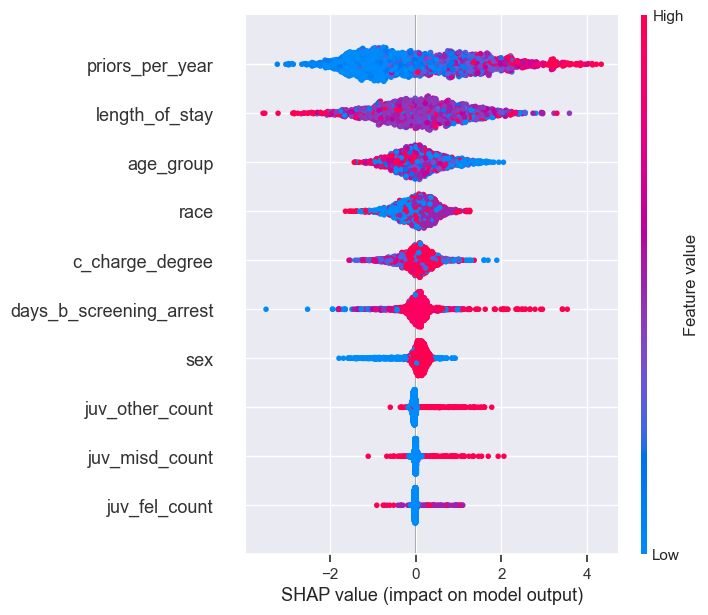

In [37]:
plt.figure(figsize=(6,7))
shap.summary_plot(shap_xgb_base_values, X_test, plot_type="dot",\
                  plot_size=None, show=False)
plt.show()

### 5.4) Studying Interactions with SHAP Interaction Values

First, inititalize SHAP's tree explainer but instead of deriving SHAP values used SHAP interaction values:

In [38]:
shap_xgb_base_interact_values = shap_xgb_base_explainer.shap_interaction_values(X_test)

We can also plot these in a `summary_plot`:

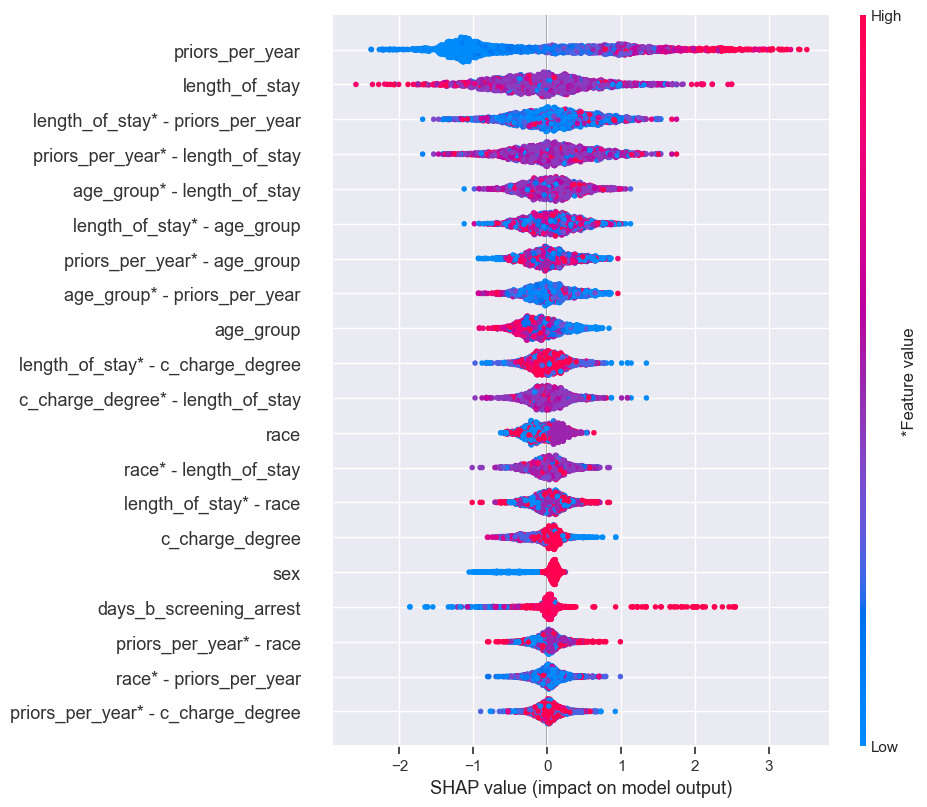

In [39]:
plt.figure(figsize=(7,7))
shap.summary_plot(shap_xgb_base_interact_values, X_test,\
                  plot_type="compact_dot", sort=True)
plt.show()

However, the above plot is hard to read.

The following code extracts the absolute mean interaction values per feature pair and puts them in a heatmap. Then, zeroes the diagonals in the heatmap (because these aren't interaction values) and then plots the heatmap with the labels.

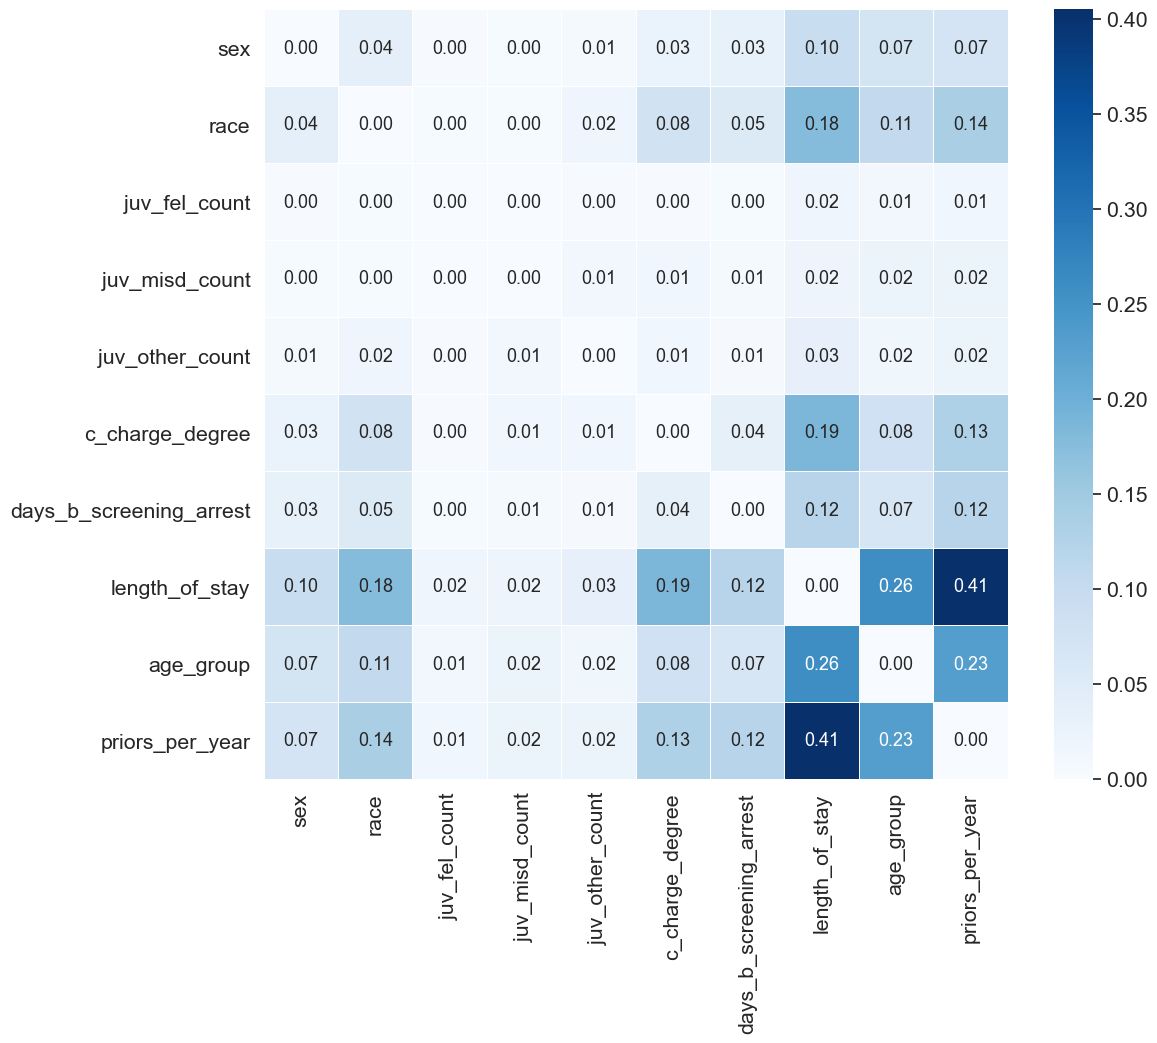

In [40]:
shap_xgb_base_interact_avgs = np.abs(shap_xgb_base_interact_values).mean(0)
np.fill_diagonal(shap_xgb_base_interact_avgs, 0)
shap_xgb_base_interact_df = pd.DataFrame(shap_xgb_base_interact_avgs)
shap_xgb_base_interact_df.columns = X_test.columns
shap_xgb_base_interact_df.index = X_test.columns

plt.figure(figsize=(12,10))
sns.set(font_scale=1.4)
sns.heatmap(shap_xgb_base_interact_df, cmap='Blues', annot=True,\
            annot_kws={'size':13}, fmt='.2f', linewidths=.5)
plt.show()

## 6) Implementing Model Constraints in XGBoost

### 6.1) Making Copy of Train/Test w/o Race

In [41]:
X_train_con = X_train.drop(['race'], axis=1).copy()
X_test_con = X_test.drop(['race'], axis=1).copy()

### 6.2) Setting Regularization and Constraint Parameters

In [42]:
#Best Parameters for this Model
best_xgb_params = {'eta': 1.3, 'max_depth': 8, 'reg_alpha': 0.4451,\
                   'reg_lambda': 0.7168, 'scale_pos_weight': 0.9914}

#Constraint Parameters
mono_con = (0,0,0,0,0,0,0,0,1)
interact_con = [[4, 5, 6, 7, 8],[0, 1, 2, 3]]

### 6.3) Training Constrained Model

In [43]:
xgb_con_mdl = xgb.XGBClassifier(seed=rand,\
                                monotone_constraints=mono_con,\
                                interaction_constraints=interact_con,\
                                **best_xgb_params)
xgb_con_mdl = xgb_con_mdl.fit(X_train_con, y_train)

[07:55:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### 6.4) Evaluate Predictive Performance of Constrained Model

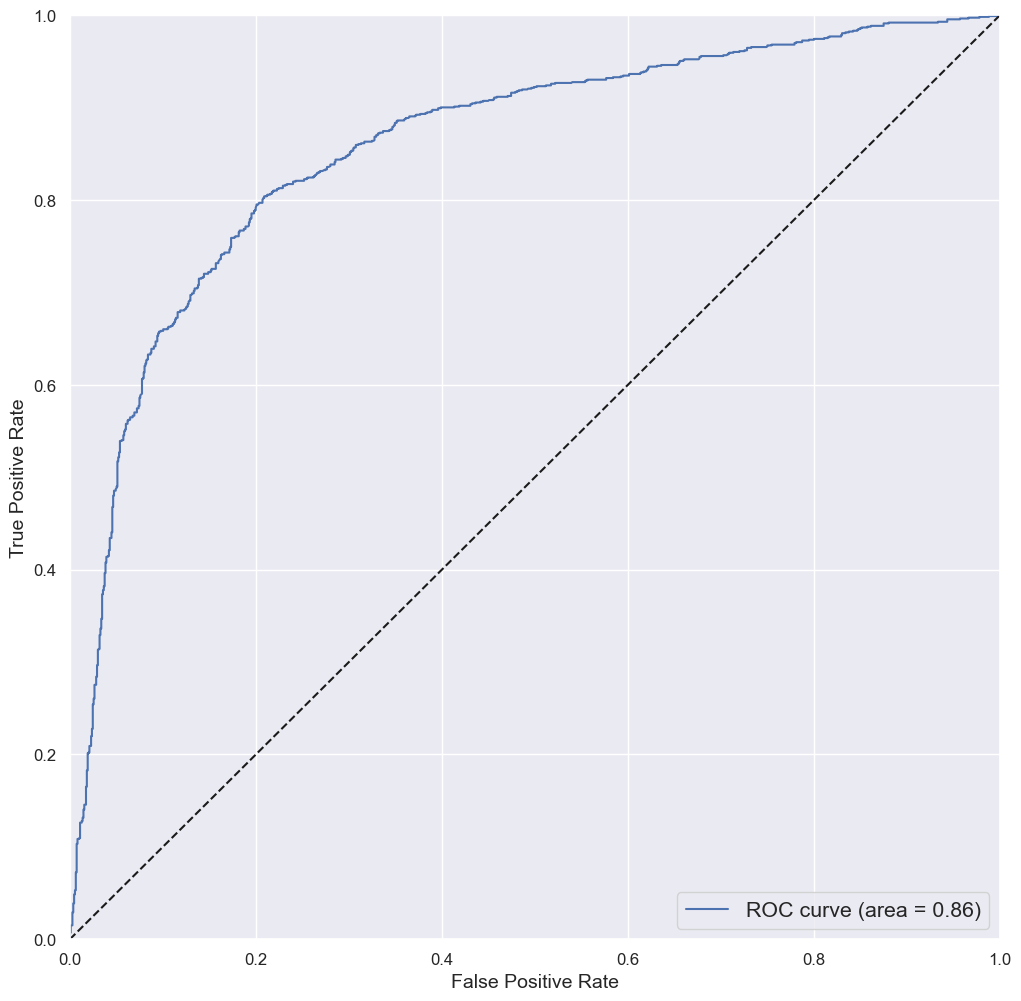

Accuracy_train:  0.9211		Accuracy_test:   0.7950
Precision_test:  0.7934		Recall_test:     0.8067
ROC-AUC_test:    0.8575		F1_test:         0.8000		MCC_test: 0.5898


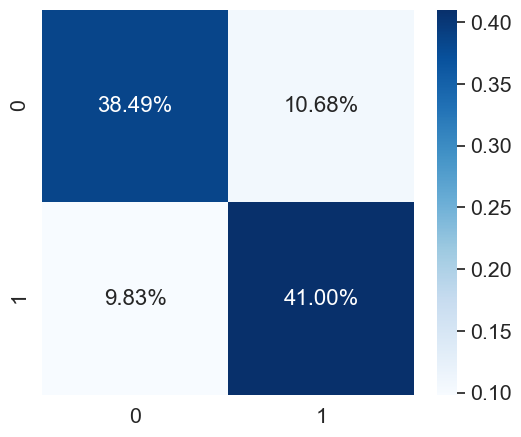

In [44]:
y_train_con_pred, y_test_con_prob, y_test_con_pred =\
                                                evaluate_class_mdl(xgb_con_mdl, X_train_con, X_test_con, y_train, y_test)

### 6.5) Comparing SHAP Summary b/w Base and Constrained Models

We will do the same as before but with the constrained model:

In [45]:
shap_xgb_con_explainer = shap.TreeExplainer(xgb_con_mdl)
shap_xgb_con_values = shap_xgb_con_explainer.shap_values(X_test_con)

Let's place summary plots side-by-side:

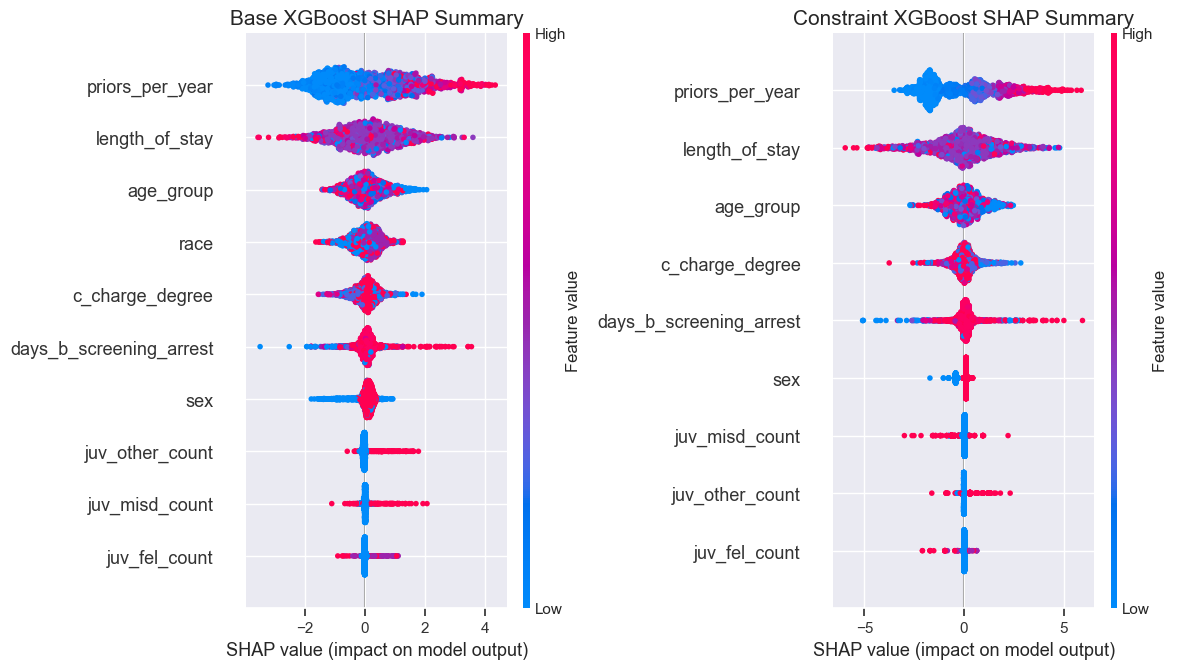

In [46]:
plt.figure(figsize=(12,7))

ax0 = plt.subplot(1, 2, 1)
shap.summary_plot(shap_xgb_base_values, X_test, plot_type="dot",\
                  plot_size=None, show=False)
ax0.set_title("Base XGBoost SHAP Summary", fontsize=15)

ax1 = plt.subplot(1, 2, 2)
shap.summary_plot(shap_xgb_con_values, X_test_con, plot_type="dot",\
                  plot_size=None, show=False)
ax1.set_title("Constraint XGBoost SHAP Summary", fontsize=15)

plt.tight_layout()
plt.subplots_adjust(wspace=0.8)
plt.show()

### 5.4) Contrasting Interactions b/w Base and Constraint Models

We can get the interaction values for the constrained models:

In [47]:
shap_xgb_con_interact_values = shap_xgb_con_explainer.shap_interaction_values(X_test_con)

We will generate the matrix for these interaction values:

In [48]:
shap_xgb_con_interact_avgs = np.abs(shap_xgb_con_interact_values).mean(0)
np.fill_diagonal(shap_xgb_con_interact_avgs, 0)
shap_xgb_con_interact_df = pd.DataFrame(shap_xgb_con_interact_avgs)
shap_xgb_con_interact_df.columns = X_test_con.columns
shap_xgb_con_interact_df.index = X_test_con.columns

We can place this matrix side by side along with that of the base model:

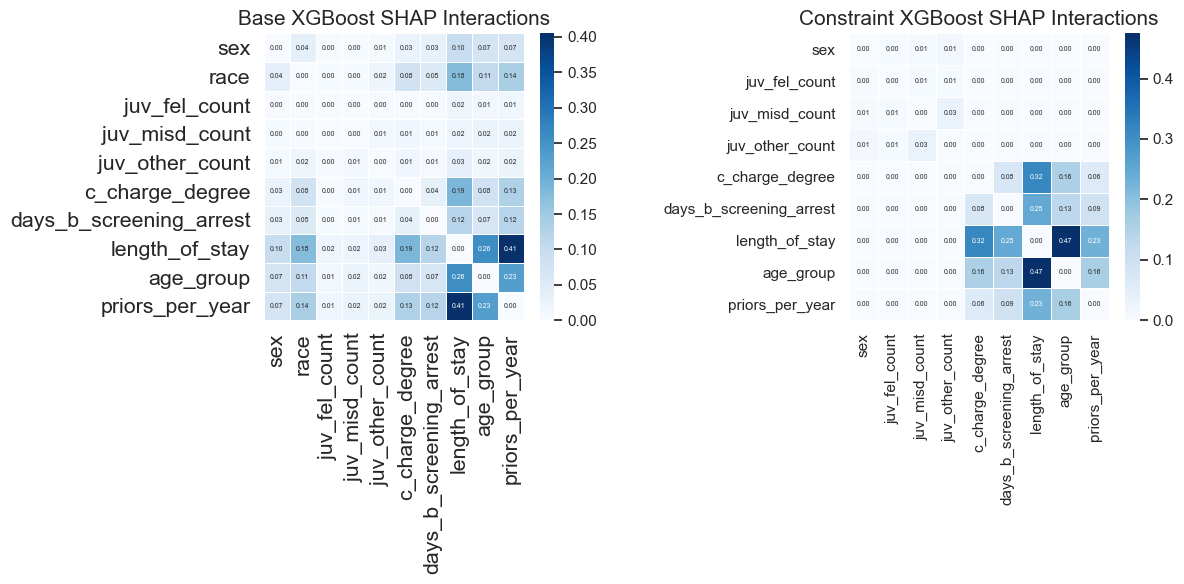

In [49]:
plt.figure(figsize=(12,6))

ax0 = plt.subplot(1, 2, 1)
sns.set(font_scale=1)
sns.heatmap(shap_xgb_base_interact_df, cmap='Blues', annot=True,\
            annot_kws={'size':5}, fmt='.2f', linewidths=.5)
ax0.set_title("Base XGBoost SHAP Interactions", fontsize=15)

ax1 = plt.subplot(1, 2, 2)
sns.heatmap(shap_xgb_con_interact_df, cmap='Blues', annot=True,\
            annot_kws={'size':5}, fmt='.2f', linewidths=.5)
ax1.set_title("Constraint XGBoost SHAP Interactions", fontsize=15)

plt.tight_layout()
plt.subplots_adjust(wspace=0.8)
plt.show()

### 5.5) Inspect How Models changed Contour Map for Priors per Year 

The base model first:

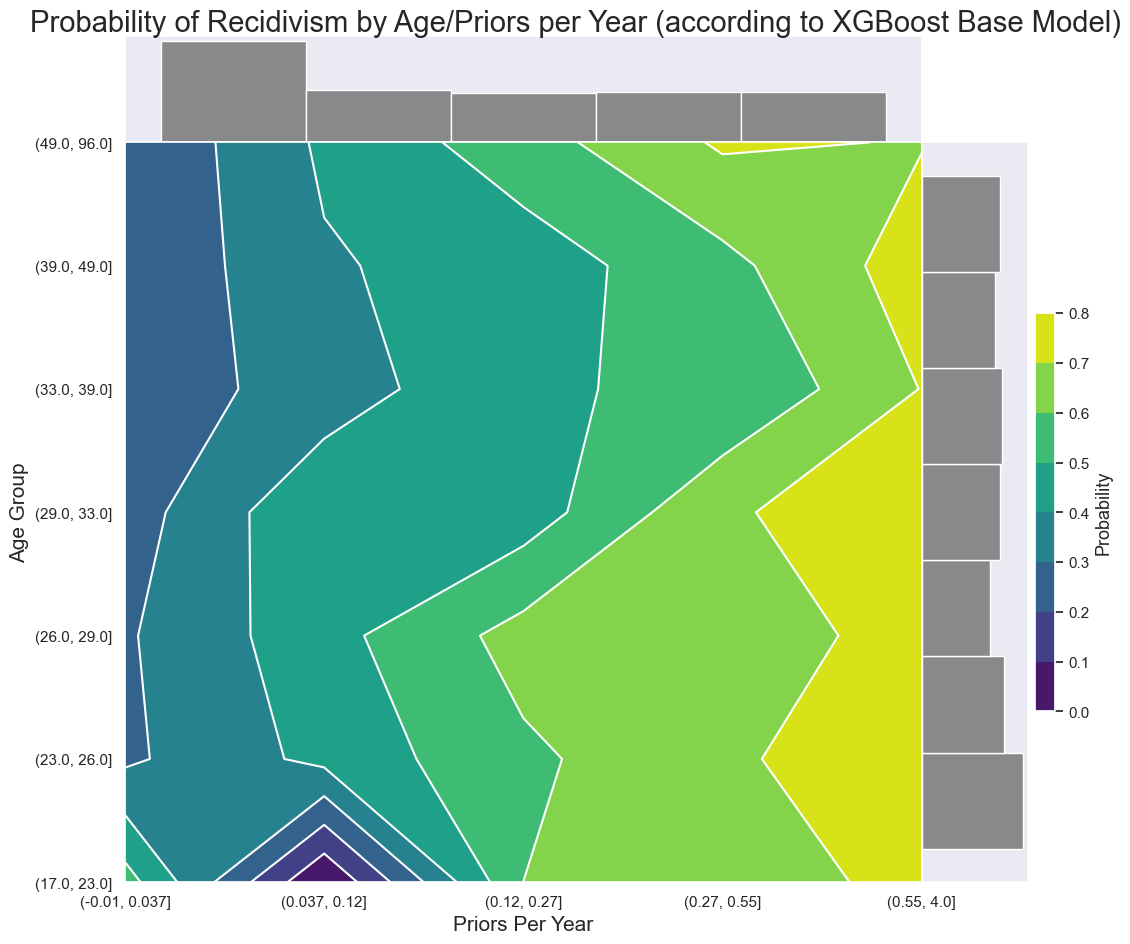

In [50]:
plot_prob_contour_map(recidivism_df.priors_per_year, recidivism_df.age_group, \
                                 recidivism_df.is_recid, y_intervals=ordenc.categories_[2],\
                                 x_intervals=6, use_quartiles=True, xlabel='Priors Per Year',\
                                 ylabel='Age Group', X_df=X_test, x_col='priors_per_year',\
                                 y_col='age_group', model=xgb_base_mdl,\
                title='Probability of Recidivism by Age/Priors per Year (according to XGBoost Base Model)')

Now, the constrained model:

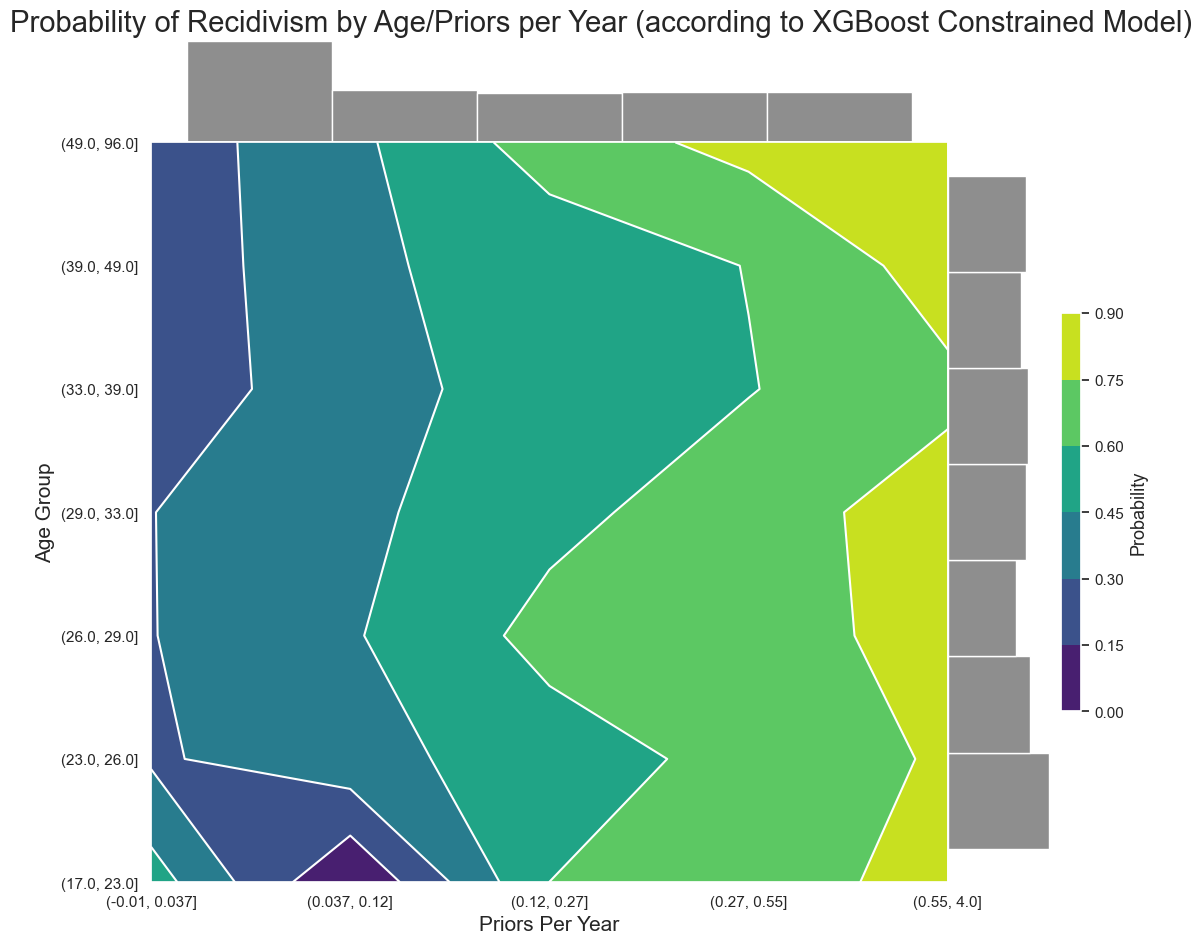

In [51]:
plot_prob_contour_map(recidivism_df.priors_per_year, recidivism_df.age_group,\
                                 recidivism_df.is_recid, y_intervals=ordenc.categories_[2],\
                                 x_intervals=6, use_quartiles=True, xlabel='Priors Per Year',\
                                 ylabel='Age Group', X_df=X_test_con, x_col='priors_per_year',\
                                 y_col='age_group', model=xgb_con_mdl,\
                title='Probability of Recidivism by Age/Priors per Year (according to XGBoost Constrained Model)')

As you can see, they are simpler contours.

### 5.6) Comparing Fairness

We will plot two plots at a time, the first for the base model and the second for the constrained model. We want to make sure that from an **outcome perspective**, the constrained model did not make matters significantly worse for our features that are usually "protected". There are bias mitigation methods that can curb any disparities in these metrics (which we won't go over in this session).

**For Predictive Performance Metrics**

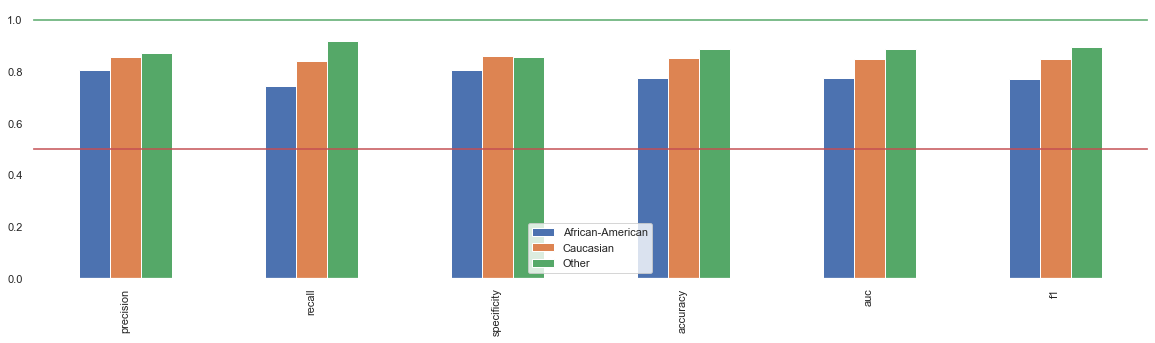

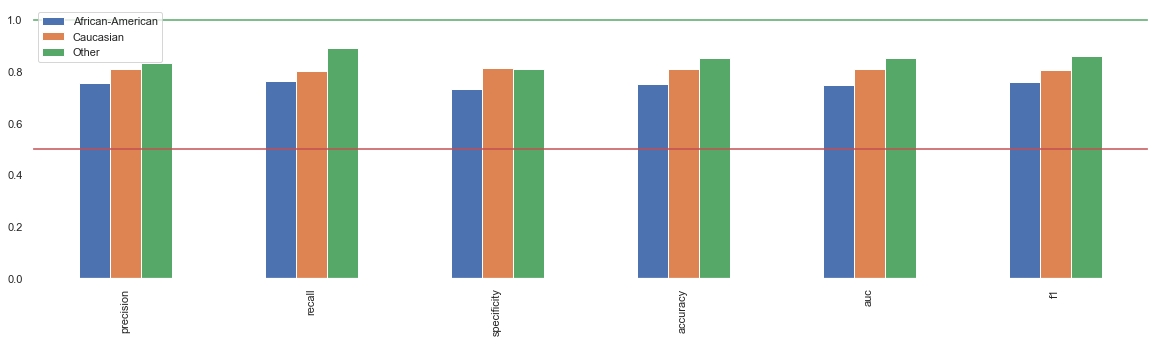

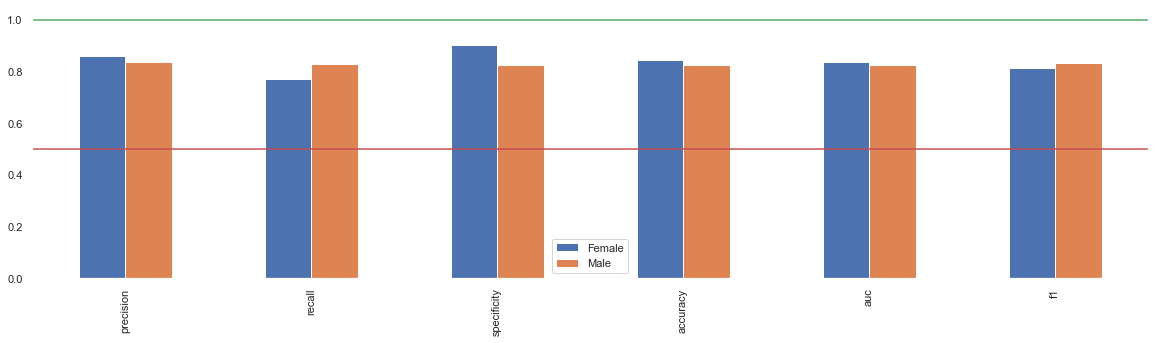

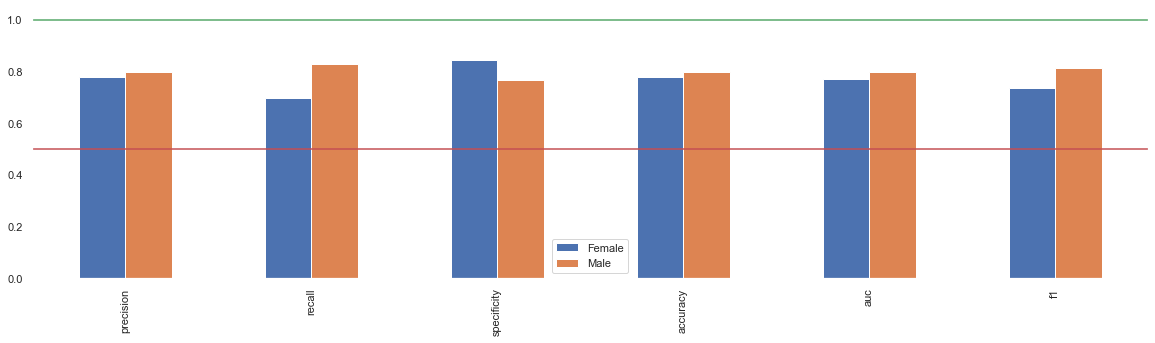

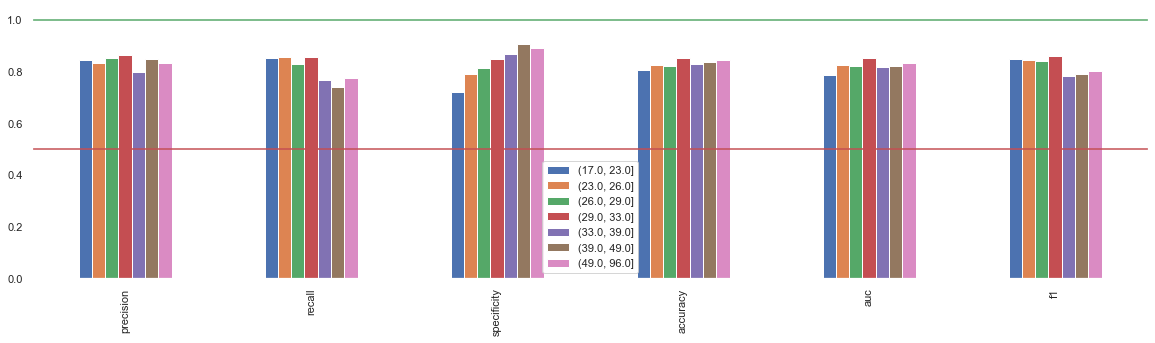

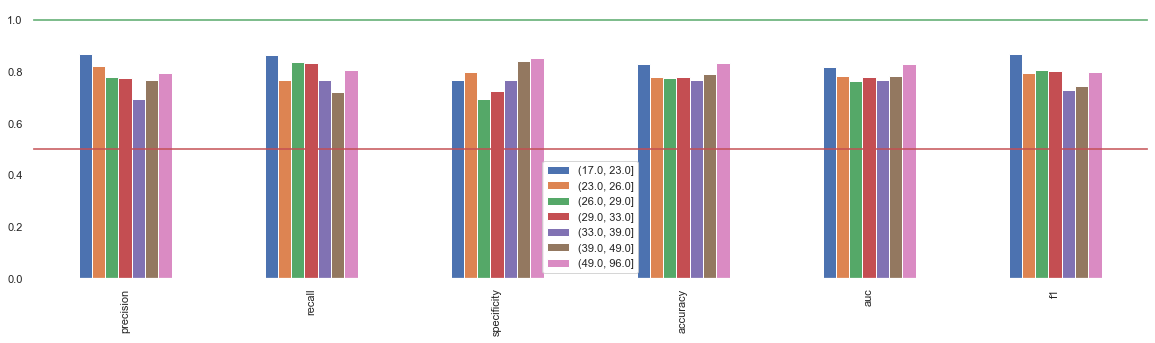

In [52]:
%matplotlib inline
protected_cols_l = ["race", "sex", "age_group"]
for p in protected_cols_l:
    _ = xai.metrics_plot(
        y_test, 
        y_test_base_prob, 
        df=X_test_display, 
        cross_cols=[p],
        categorical_cols=protected_cols_l)
    _ = xai.metrics_plot(
        y_test, 
        y_test_con_prob, 
        df=X_test_display, 
        cross_cols=[p],
        categorical_cols=protected_cols_l)

**For ROC Curves**

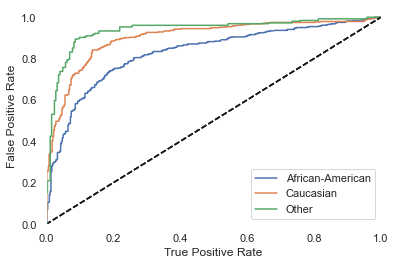

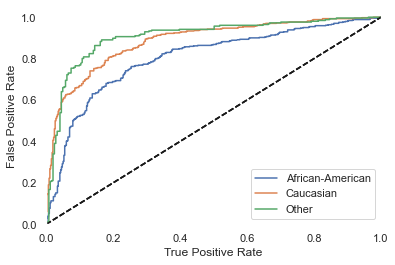

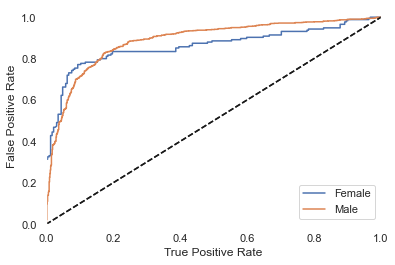

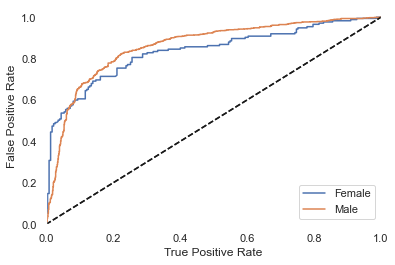

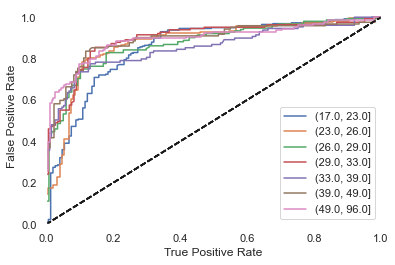

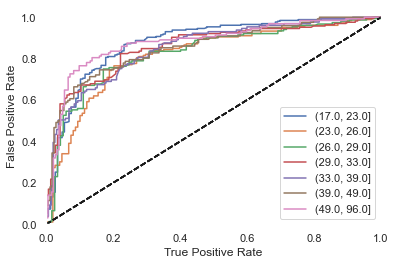

In [53]:
%matplotlib inline
protected_cols_l = ["race", "sex", "age_group"]
for p in protected_cols_l:
    _ = xai.roc_plot(
        y_test, 
        y_test_base_prob, 
        df=X_test_display, 
        cross_cols=[p],
        categorical_cols=protected_cols_l)
    _ = xai.roc_plot(
        y_test, 
        y_test_con_prob, 
        df=X_test_display, 
        cross_cols=[p],
        categorical_cols=protected_cols_l)

**For Precision-Recall Curve**

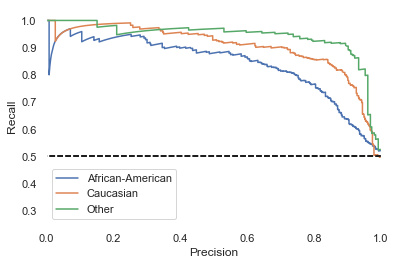

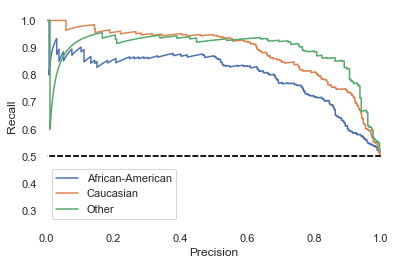

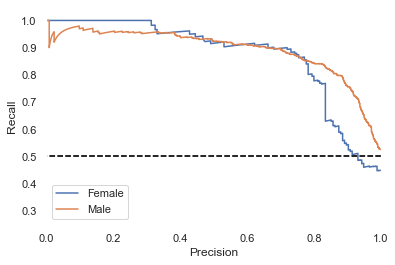

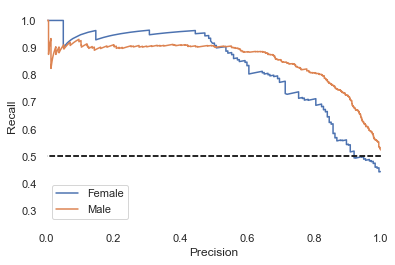

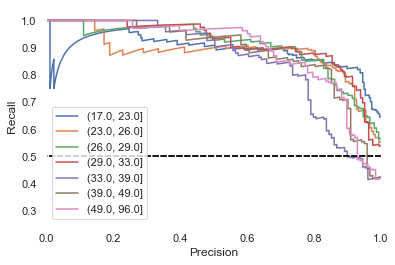

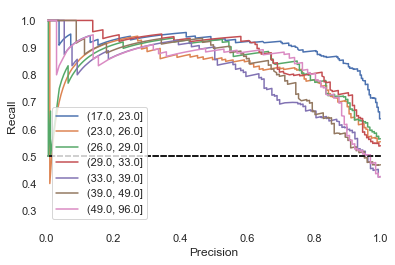

In [54]:
for p in protected_cols_l:
    _ = xai.pr_plot(
        y_test, 
        y_test_base_prob, 
        df=X_test_display, 
        cross_cols=[p],
        categorical_cols=protected_cols_l)
    _ = xai.pr_plot(
        y_test, 
        y_test_con_prob, 
        df=X_test_display, 
        cross_cols=[p],
        categorical_cols=protected_cols_l)

## 6) Implementing Model Constraints in Tensorflow Lattice

### 6.1) Subsetting Training Data

To simplify this exercise we will only use three of the most prominent features:

In [55]:
X_train_con.iloc[:,-3:]

,length_of_stay,age_group,priors_per_year
3643,52.916667,3,1.142857
9631,0.166667,1,0.125000
5918,92.166667,6,0.000000
8036,-157.750000,2,0.000000
599,2.166667,5,0.695652
...,...,...,...
6200,0.000000,6,0.000000
501,184.416667,4,0.277778
6782,0.166667,1,0.428571
4444,152.875000,5,0.037037


In [56]:
X_train_tfl = X_train_con.iloc[:,-3:]
X_test_tfl = X_test_con.iloc[:,-3:]

### 6.2) Initializing Model and Lattice Inputs

Define the lattice sizes:

In [57]:
lattice_sizes = [7, 7, 4] 

And model inputs:

In [58]:
model_inputs = []
lattice_inputs = []

length_input = tf.keras.layers.Input(shape=[1], name='length_of_stay')
lattice_inputs.append(tfl.layers.PWLCalibration(
        name='length_calib',
        input_keypoints=np.quantile(X_train_tfl['length_of_stay'],\
                                    np.linspace(0, 1, num=8)),
        output_min=0.0,
        output_max=lattice_sizes[0] - 1.0,
        monotonicity='none',
        kernel_regularizer=('hessian', 0.0, 1e-4))(length_input))
model_inputs.append(length_input)

age_input = tf.keras.layers.Input(shape=[1], name='age_group')
lattice_inputs.append(tfl.layers.PWLCalibration(
        name='age_calib',
        input_keypoints=np.linspace(0, 6, num=7, dtype=np.float32),
        output_min=0.0,
        output_max=lattice_sizes[1] - 1.0,
        monotonicity='none',
        kernel_regularizer=('hessian', 0.0, 1e-4))(age_input))
model_inputs.append(age_input)

priors_input = tf.keras.layers.Input(shape=[1], name='priors_per_year')
lattice_inputs.append(tfl.layers.PWLCalibration(
        name='priors_calib',
        input_keypoints=np.quantile(X_train_tfl['priors_per_year'],\
                                    np.linspace(0, 1, num=4)),
        output_min=0.0,
        output_max=lattice_sizes[2] - 1.0,
        monotonicity='increasing')(priors_input))
model_inputs.append(priors_input)

### 6.3) Building Keras Model with Tensorflow Lattice Layers

Define the lattice a model output:

In [59]:
lattice = tfl.layers.Lattice(
                        name='lattice',
                        lattice_sizes=lattice_sizes,
                        monotonicities=[
                            'none', 'none', 'increasing'
                        ],
                        output_min=0.0,
                        output_max=1.0)(lattice_inputs)

model_output = tf.keras.layers.Dense(1, name='output',\
                                     activation='sigmoid')(lattice)

Connect the inputs to the output:

In [60]:
tfl_mdl = tf.keras.models.Model(\
                inputs=model_inputs,\
                outputs=model_output)

Generate a model summary:

In [61]:
tfl_mdl.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
length_of_stay (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
age_group (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
priors_per_year (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
length_calib (PWLCalibration)   (None, 1)            8           length_of_stay[0][0]             
______________________________________________________________________________________________

Plot the architecture:

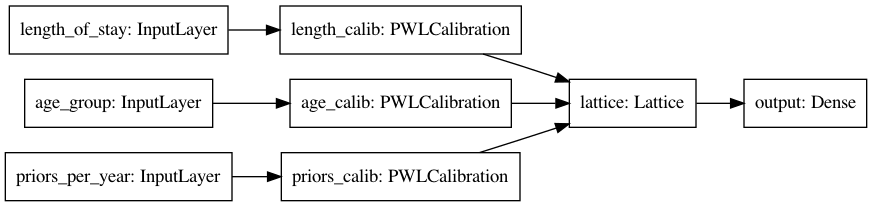

In [62]:
tf.keras.utils.plot_model(tfl_mdl, rankdir='LR')

Compile the TF Lattice model:

In [63]:
tfl_mdl.compile(loss='binary_crossentropy',\
                optimizer=tf.keras.optimizers.Adam(lr=0.004),\
                metrics=['accuracy',tf.keras.metrics.AUC(name='auc')])

### 6.4) Prepare Data

Since there are three seperate inputs in this model, we will need to split the data accordingly with `split`:

In [64]:
X_train_expand = np.split(\
                        X_train_tfl.values.astype(np.float32),\
                        indices_or_sections=3, axis=1)
y_train_expand = np.expand_dims(y_train.values.astype(np.float32), axis=1)

X_test_expand = np.split(\
                        X_test_tfl.values.astype(np.float32),\
                        indices_or_sections=3, axis=1)
y_test_expand = np.expand_dims(y_test.values.astype(np.float32), axis=1)

### 6.5) Train Model

In [65]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', verbose=1,\
                                patience=20, restore_best_weights=True) 
tfl_history = tfl_mdl.fit(X_train_expand, y_train_expand,\
                          class_weight={0:18, 1:16},
                          batch_size=128, epochs=60, validation_split=0.2,\
                          shuffle=False, callbacks=[es], verbose=1)

Epoch 1/60
56/56 [==============================] - 0s 7ms/step - loss: 11.7782 - accuracy: 0.5050 - auc: 0.4580 - val_loss: 0.6906 - val_accuracy: 0.5143 - val_auc: 0.6516
Epoch 2/60
56/56 [==============================] - 0s 2ms/step - loss: 11.6307 - accuracy: 0.5360 - auc: 0.6644 - val_loss: 0.6799 - val_accuracy: 0.6321 - val_auc: 0.6786
Epoch 3/60
56/56 [==============================] - 0s 2ms/step - loss: 11.3990 - accuracy: 0.6432 - auc: 0.6808 - val_loss: 0.6662 - val_accuracy: 0.6433 - val_auc: 0.6869
Epoch 4/60
56/56 [==============================] - 0s 2ms/step - loss: 11.1813 - accuracy: 0.6468 - auc: 0.6933 - val_loss: 0.6572 - val_accuracy: 0.6399 - val_auc: 0.6894
Epoch 5/60
56/56 [==============================] - 0s 2ms/step - loss: 11.0409 - accuracy: 0.6471 - auc: 0.6981 - val_loss: 0.6512 - val_accuracy: 0.6416 - val_auc: 0.6929
Epoch 6/60
56/56 [==============================] - 0s 2ms/step - loss: 10.9441 - accuracy: 0.6471 - auc: 0.7007 - val_loss: 0.6471 - v

### 6.6) Evaluate Model

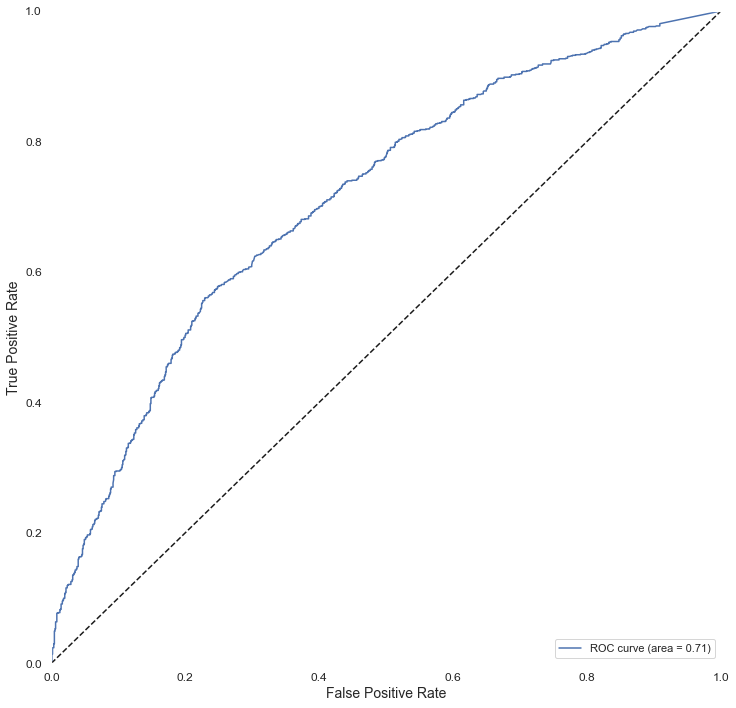

Accuracy_train:  0.6586		Accuracy_test:   0.6617
Precision_test:  0.7058		Recall_test:     0.5737
ROC-AUC_test:    0.7107		F1_test:         0.6329		MCC_test: 0.3314


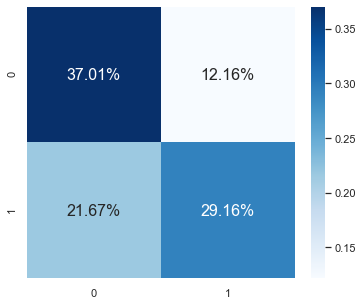

In [66]:
y_train_tfl_pred, y_test_tfl_prob, y_test_tfl_pred =\
            evaluate_class_mdl(tfl_mdl, X_train_expand, X_test_expand,\
                   y_train.values.astype(np.float32), y_test.values.astype(np.float32))

### 6.7) SHAP for Tensorflow Lattice

KernelExplainer is what you can use with any arbitrary model, but first we will need a some sample data for which we will use SHAp's built-in k-means function:

In [68]:
X_train_summary = shap.kmeans(X_train_tfl, 10)

We could do this now but we won't: 

`shap_tfl_explainer = shap.KernelExplainer(tfl_mdl.predict, X_train_summary)`

because it will throw an error because the Tensorflow Lattice predict function requires data that has been expanded into 3 seperate arrays with with the `split` function. So, for that, we will use a simple lambda function that serves as an intermediate:

In [67]:
tfl_predict_fn = lambda X: tfl_mdl.predict(np.split(X.astype(np.float32),\
                                                    indices_or_sections=3, axis=1))

Now we initialize the `KernelExplainer` with this lambda function:

In [69]:
shap_tfl_explainer = shap.KernelExplainer(tfl_predict_fn, X_train_summary)

And generate the SHAP values for our test data (can take a while):

In [70]:
%%time
shap_tfl_values = shap_tfl_explainer.shap_values(X_test_tfl)

  0%|          | 0/2229 [00:00<?, ?it/s]

CPU times: user 3min 5s, sys: 16.2 s, total: 3min 22s
Wall time: 1min 40s


Let's see the SHAP summary to examine how consistent `priors_per_year` is:

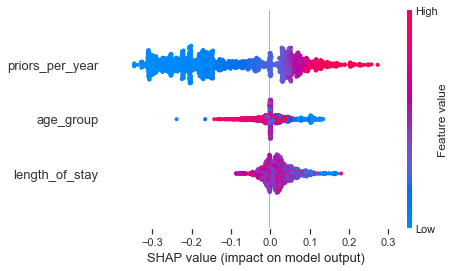

In [71]:
plt.figure(figsize=(6,4))
shap.summary_plot(shap_tfl_values[0], X_test_tfl, plot_type="dot",\
                  plot_size=None, show=False)
plt.show()